# Morphospace analysis on results of EFA

In [1]:
from pathlib import Path

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

from ktch.outline import EllipticFourierAnalysis

from utils import prepend_h_0, get_pc_scores_for_morphospace, confidence_ellipse, cvt_conf2std

## functions

In [2]:
def plot_recon_morphs(pca, efa, hue, hue_order, fig, ax,
             n_PCs_xy = [1, 2], lmax = 20, morph_num = 3, morph_scale = 1.0, morph_color = "lightgray", morph_alpha = 0.7, 
             standardized_by_1st_ellipsoid = False):
    
    pc_scores_h, pc_scores_v = get_pc_scores_for_morphospace(ax, morph_num)
    print("PC_h: ", pc_scores_h, ", PC_v: ", pc_scores_v)
    for pc_score_h in pc_scores_h:
        for pc_score_v in pc_scores_v:
            pc_score = np.zeros(pca.n_components_)
            n_PC_h, n_PC_v = n_PCs_xy
            pc_score[n_PC_h-1] = pc_score_h
            pc_score[n_PC_v-1] = pc_score_v

            arr_coef = prepend_h_0(pca.inverse_transform([pc_score]))

            
            ax_width = ax.get_window_extent().width
            fig_width = fig.get_window_extent().width
            fig_height = fig.get_window_extent().height
            morph_size = morph_scale*ax_width/(fig_width*morph_num)
            loc = ax.transData.transform((pc_score_h, pc_score_v))
            axins = fig.add_axes([loc[0]/fig_width-morph_size/2, loc[1]/fig_height-morph_size/2,
                                       morph_size, morph_size], anchor='C')
            
            coords = efa.inverse_transform(arr_coef)
            x = coords[0][:,0]
            y = coords[0][:,1]
            
            axins.plot(x.astype(float),y.astype(float),color=morph_color, alpha = morph_alpha)
            axins.axis('equal')
            axins.axis('off') 

def plot_confidence_ellipse(pred_pca, n_PCs, cat, std, ax, palette="tab10", cat_order=None, center=False):
    if cat_order is None:
        catnum_dict = {c: idx for idx, c in enumerate(sorted(set(cat)))}
        num_colors = len(np.unique(cat))
    else:
        catnum_dict = {c: idx for idx, c in enumerate(cat_order)}
        num_colors = len(cat_order)

    for key in cat:
        x = pred_pca[pd.Series(cat) == key, n_PCs[0]]
        y = pred_pca[pd.Series(cat) == key, n_PCs[1]]
        if len(x) < 2:
            continue
        confidence_ellipse(
            x,
            y,
            ax=ax,
            n_std=std,
            linewidth=1.5,
            edgecolor=sns.color_palette(n_colors=num_colors, palette=palette)[
                catnum_dict[key]
            ],
            linestyle=["-", "--", "-.", ":"][catnum_dict[key]%4]
        )
        if center:
            ax.scatter(
                [np.mean(x)], [np.mean(y)], s=200, 
                c=[sns.color_palette(n_colors=num_colors, palette=palette)[catnum_dict[key]]], 
                marker = "+", zorder=2)

def plot_pc_contrib(pca, n_PCs = (1,2,3),
               sd_values = (-2, -1, 0, 1, 2), 
               lmax = 30, 
               dpi = 200,
                standardized = True,
                edge_color = "lightgray", edge_width=3,
               face_color = "none", morph_alpha = 1.0):
    num_PCs = len(n_PCs)
    num_sd_values = len(sd_values)
    fig = plt.figure(figsize=(15,3*num_PCs),dpi=dpi)
    efa = EllipticFourierAnalysis(n_harmonics=lmax)
    
    for i, n_PC in enumerate(n_PCs):
        sd = np.sqrt(pca.explained_variance_[n_PC-1])
        sd_arr = np.array(sd_values)*sd
        for j in range(num_sd_values):
            ax = fig.add_subplot(num_PCs,num_sd_values,num_sd_values*i+j+1)
            pc_score = np.zeros(pca.n_components_)
            pc_score[i] = sd_arr[j]
            arr_inv = pca.inverse_transform([pc_score])
            
            if standardized:
                arr_inv = prepend_h_0(arr_inv)
            
            coords = efa.inverse_transform(arr_inv)
            x = coords[0][:,0]
            y = coords[0][:,1]
            
            ax.fill(x.astype(float),y.astype(float),facecolor=face_color, edgecolor=edge_color, linewidth= edge_width, alpha = morph_alpha)
            ax.axis('equal')
            ax.axis('off') 
    return fig

## prep data

In [3]:
df_meta_2d = pd.read_csv("../data/meta_2d_20231012_HN.csv",index_col="index_meta")
df_meta_2d.index.name=None

In [4]:
dict_2d_filename2idx = pd.read_csv(
    "../data/dict_id_2d_filename2idx.csv", 
    names=["idx"],index_col=0
).to_dict()["idx"]

df_efc_h30_orig = pd.read_csv("../data/efa_coef_h30.csv")
df_efc_h30_orig = df_efc_h30_orig.set_index(df_efc_h30_orig.name.replace(dict_2d_filename2idx).rename(None))

n_h = 30
col_coef = [c+str(i) for c in ["A", "B", "C", "D"] for i in range(1, n_h+1)]
df_efc_h30 = df_efc_h30_orig[col_coef]

In [5]:
efa_h30 = EllipticFourierAnalysis(n_harmonics=30)

## PCA

In [6]:
pca_h30 = PCA(n_components=30).set_output(transform="pandas")

df_pca_h30 = pca_h30.fit_transform(df_efc_h30)
df_pca_h30 = pd.concat([df_pca_h30, df_efc_h30_orig[["area", "phase", "site"]]],axis=1)

<Axes: >

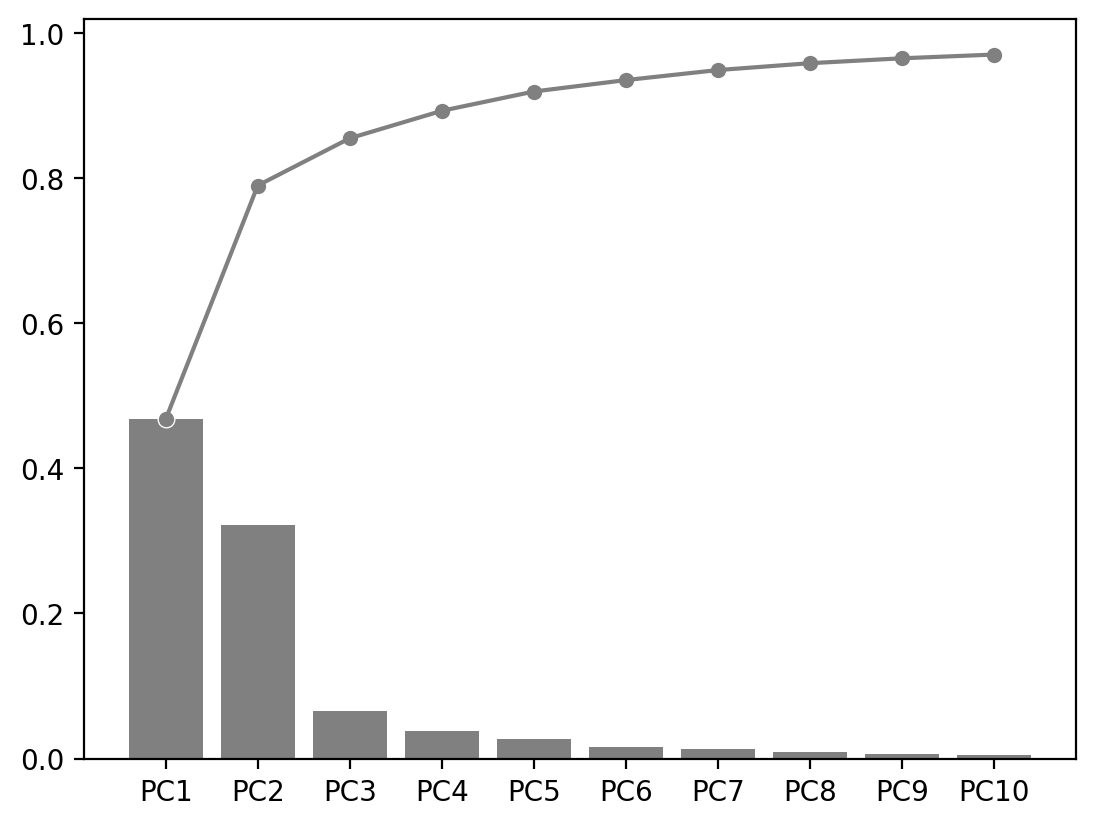

In [8]:
fig = plt.figure(dpi=200)

pca = pca_h30
pc_end = 10

pc_evr = pca.explained_variance_ratio_[0:pc_end]
pc_cum = np.cumsum(pc_evr)

sns.barplot(x=["PC"+str(i+1) for i in range(pc_end)], y=pc_evr, color="gray")
sns.lineplot(x=["PC"+str(i+1) for i in range(pc_end)], y= pc_cum, color="gray")
sns.scatterplot(x=["PC"+str(i+1) for i in range(pc_end)], y=pc_cum, color="gray")

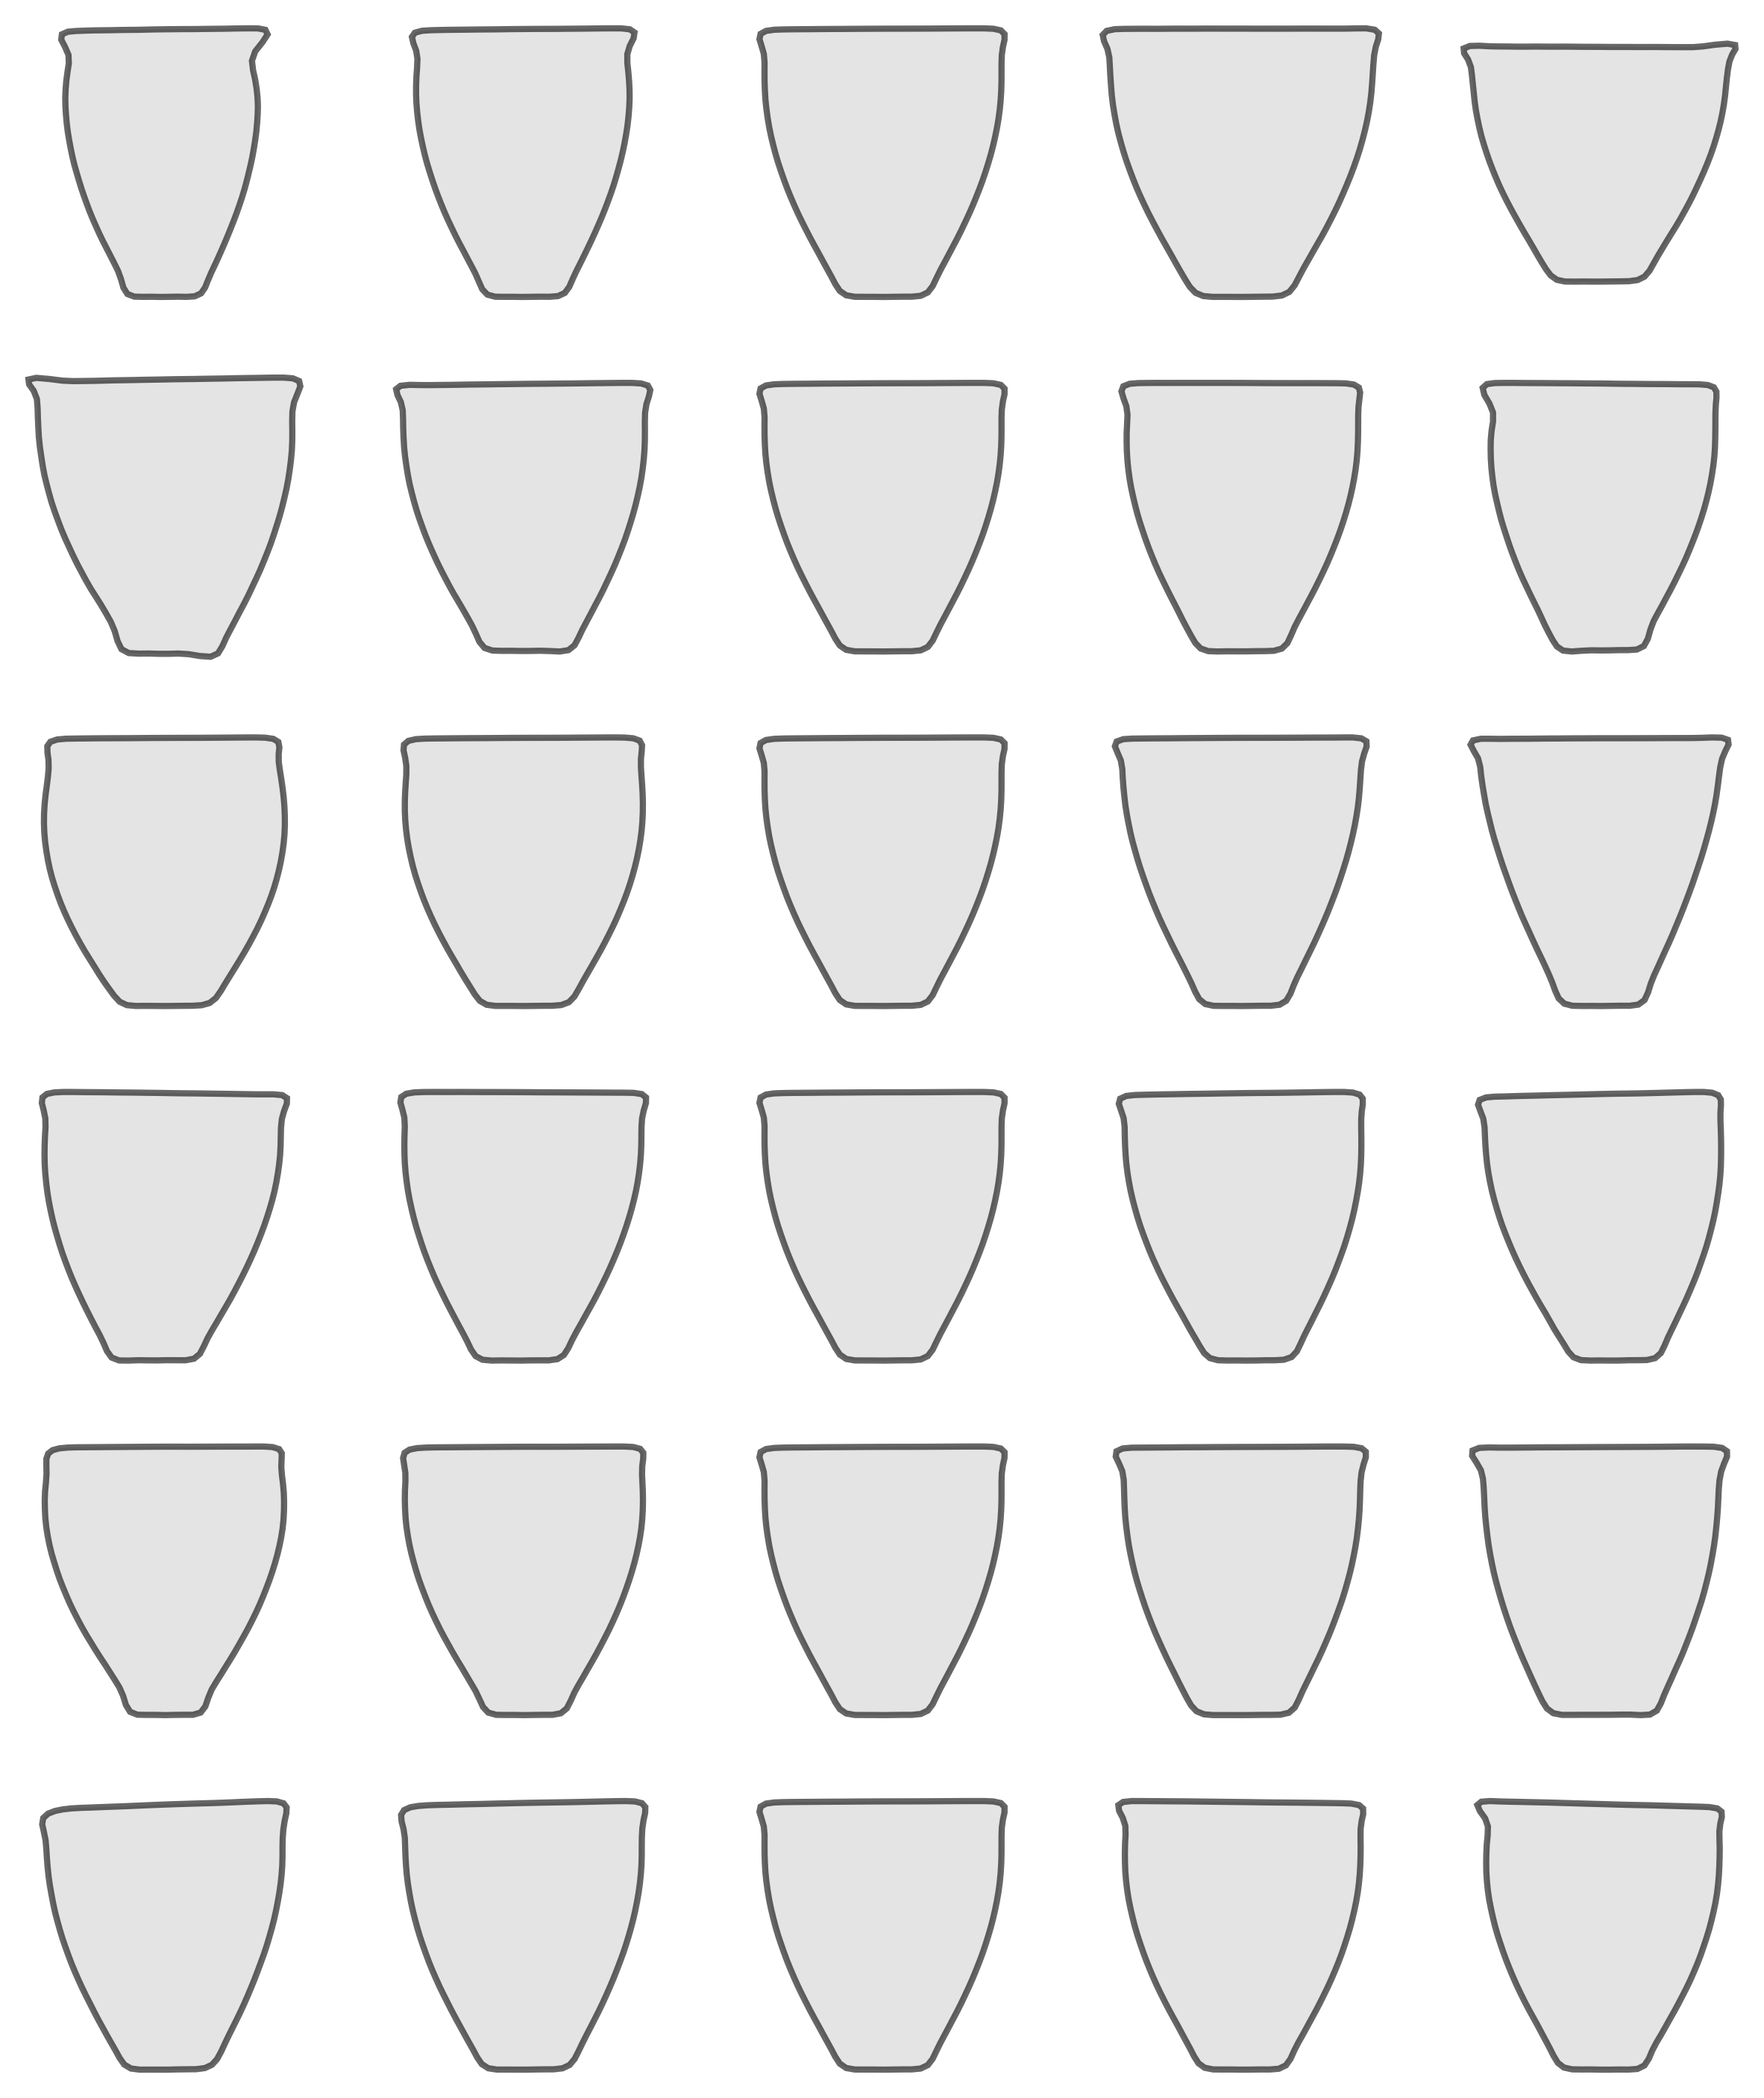

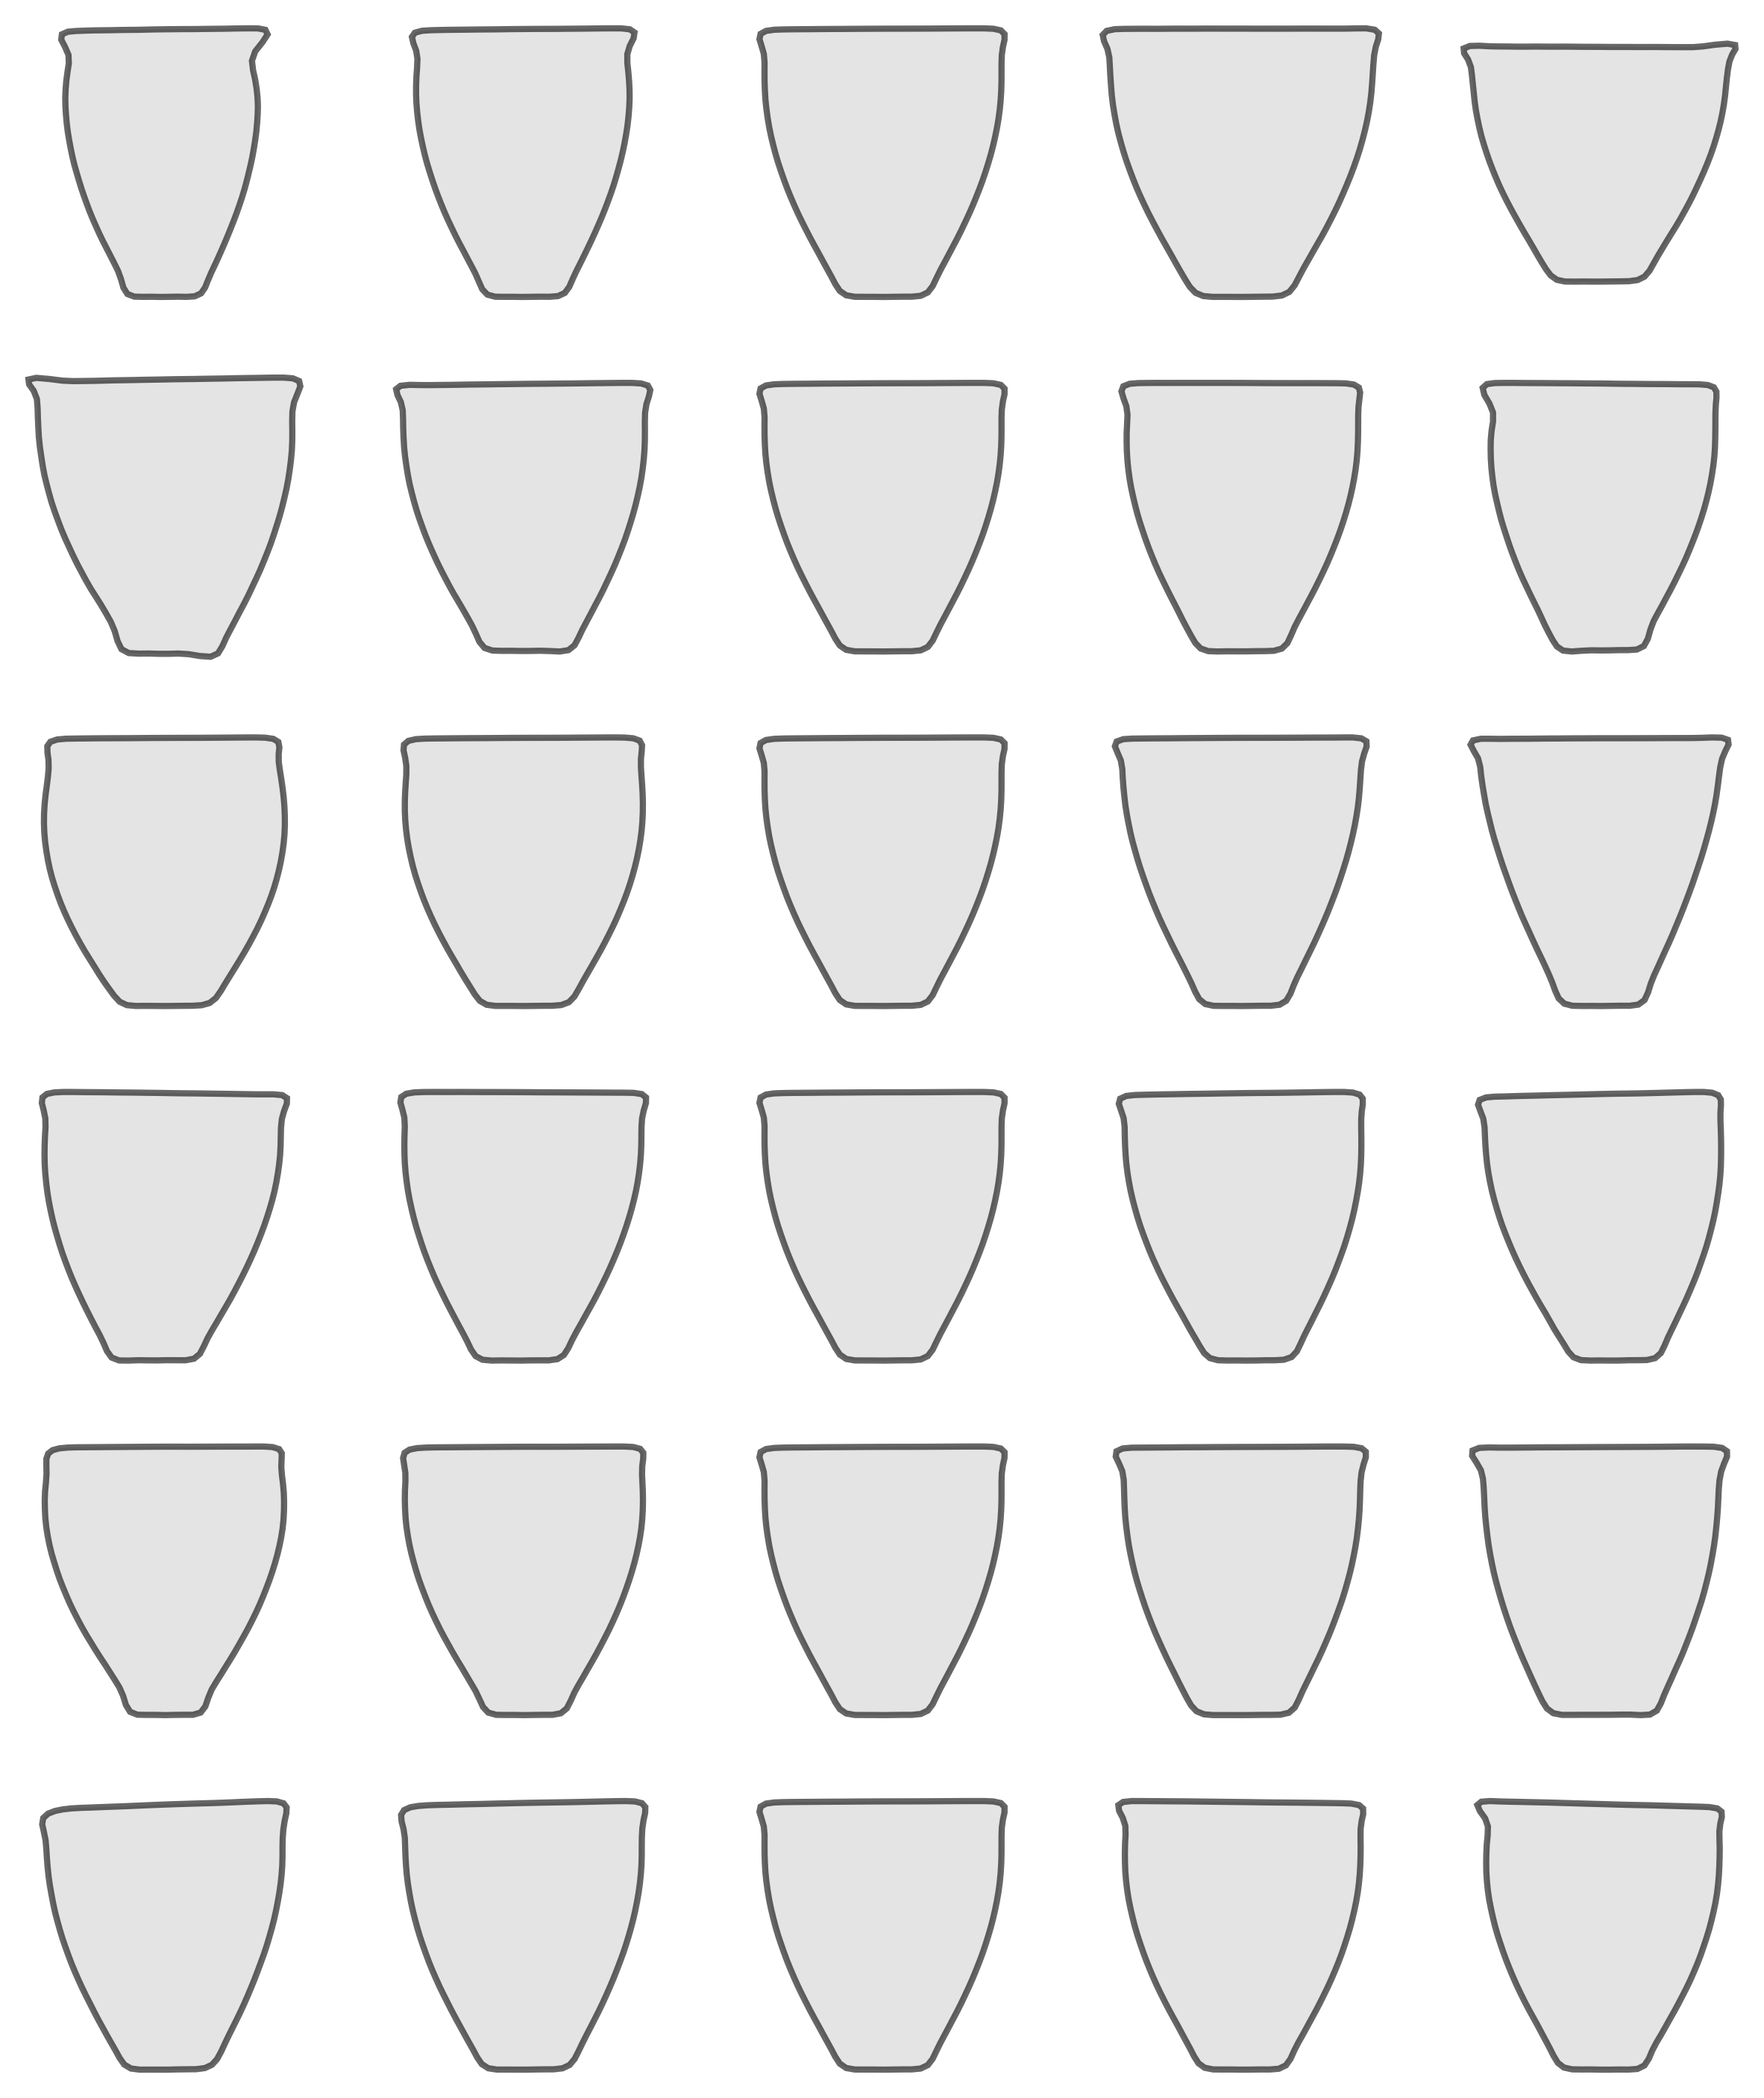

In [9]:
plot_pc_contrib(
    pca, n_PCs=[1, 2, 3, 4, 5, 6], 
    face_color="lightgray", edge_color="black", morph_alpha=0.6
)

PC_h:  [-0.1656   -0.058175  0.04925   0.156675  0.2641  ] , PC_v:  [-0.1838   -0.069625  0.04455   0.158725  0.2729  ]
PC_h:  [-0.1838   -0.069625  0.04455   0.158725  0.2729  ] , PC_v:  [-0.0735  -0.03035  0.0128   0.05595  0.0991 ]
PC_h:  [-0.0735  -0.03035  0.0128   0.05595  0.0991 ] , PC_v:  [-0.1656   -0.058175  0.04925   0.156675  0.2641  ]


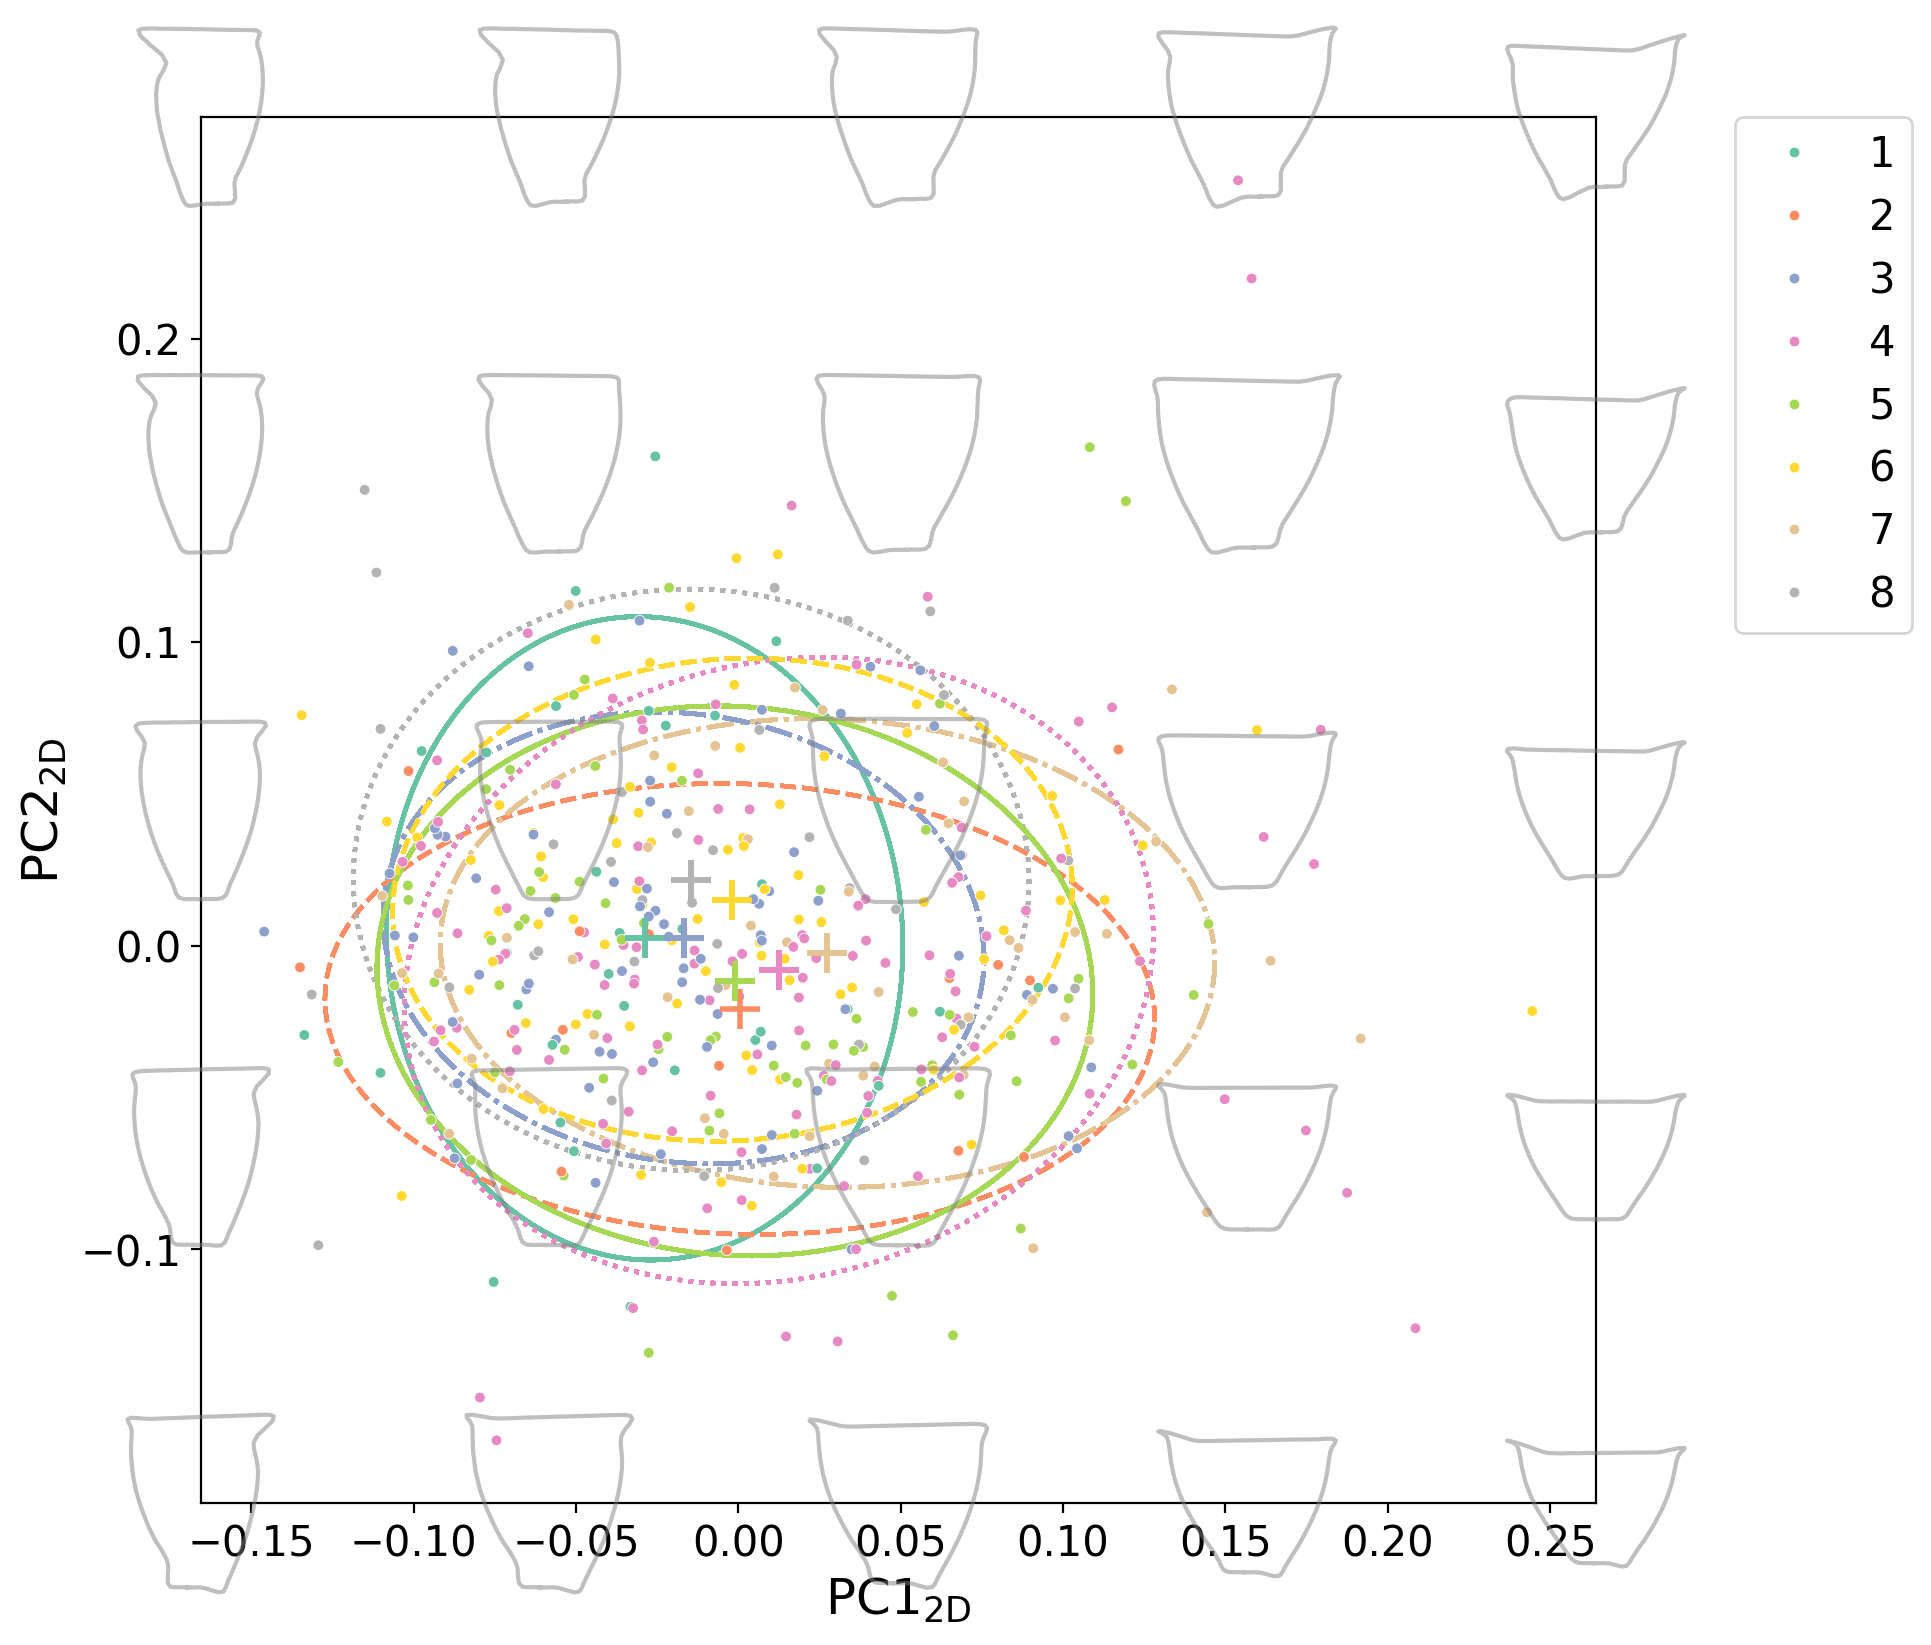

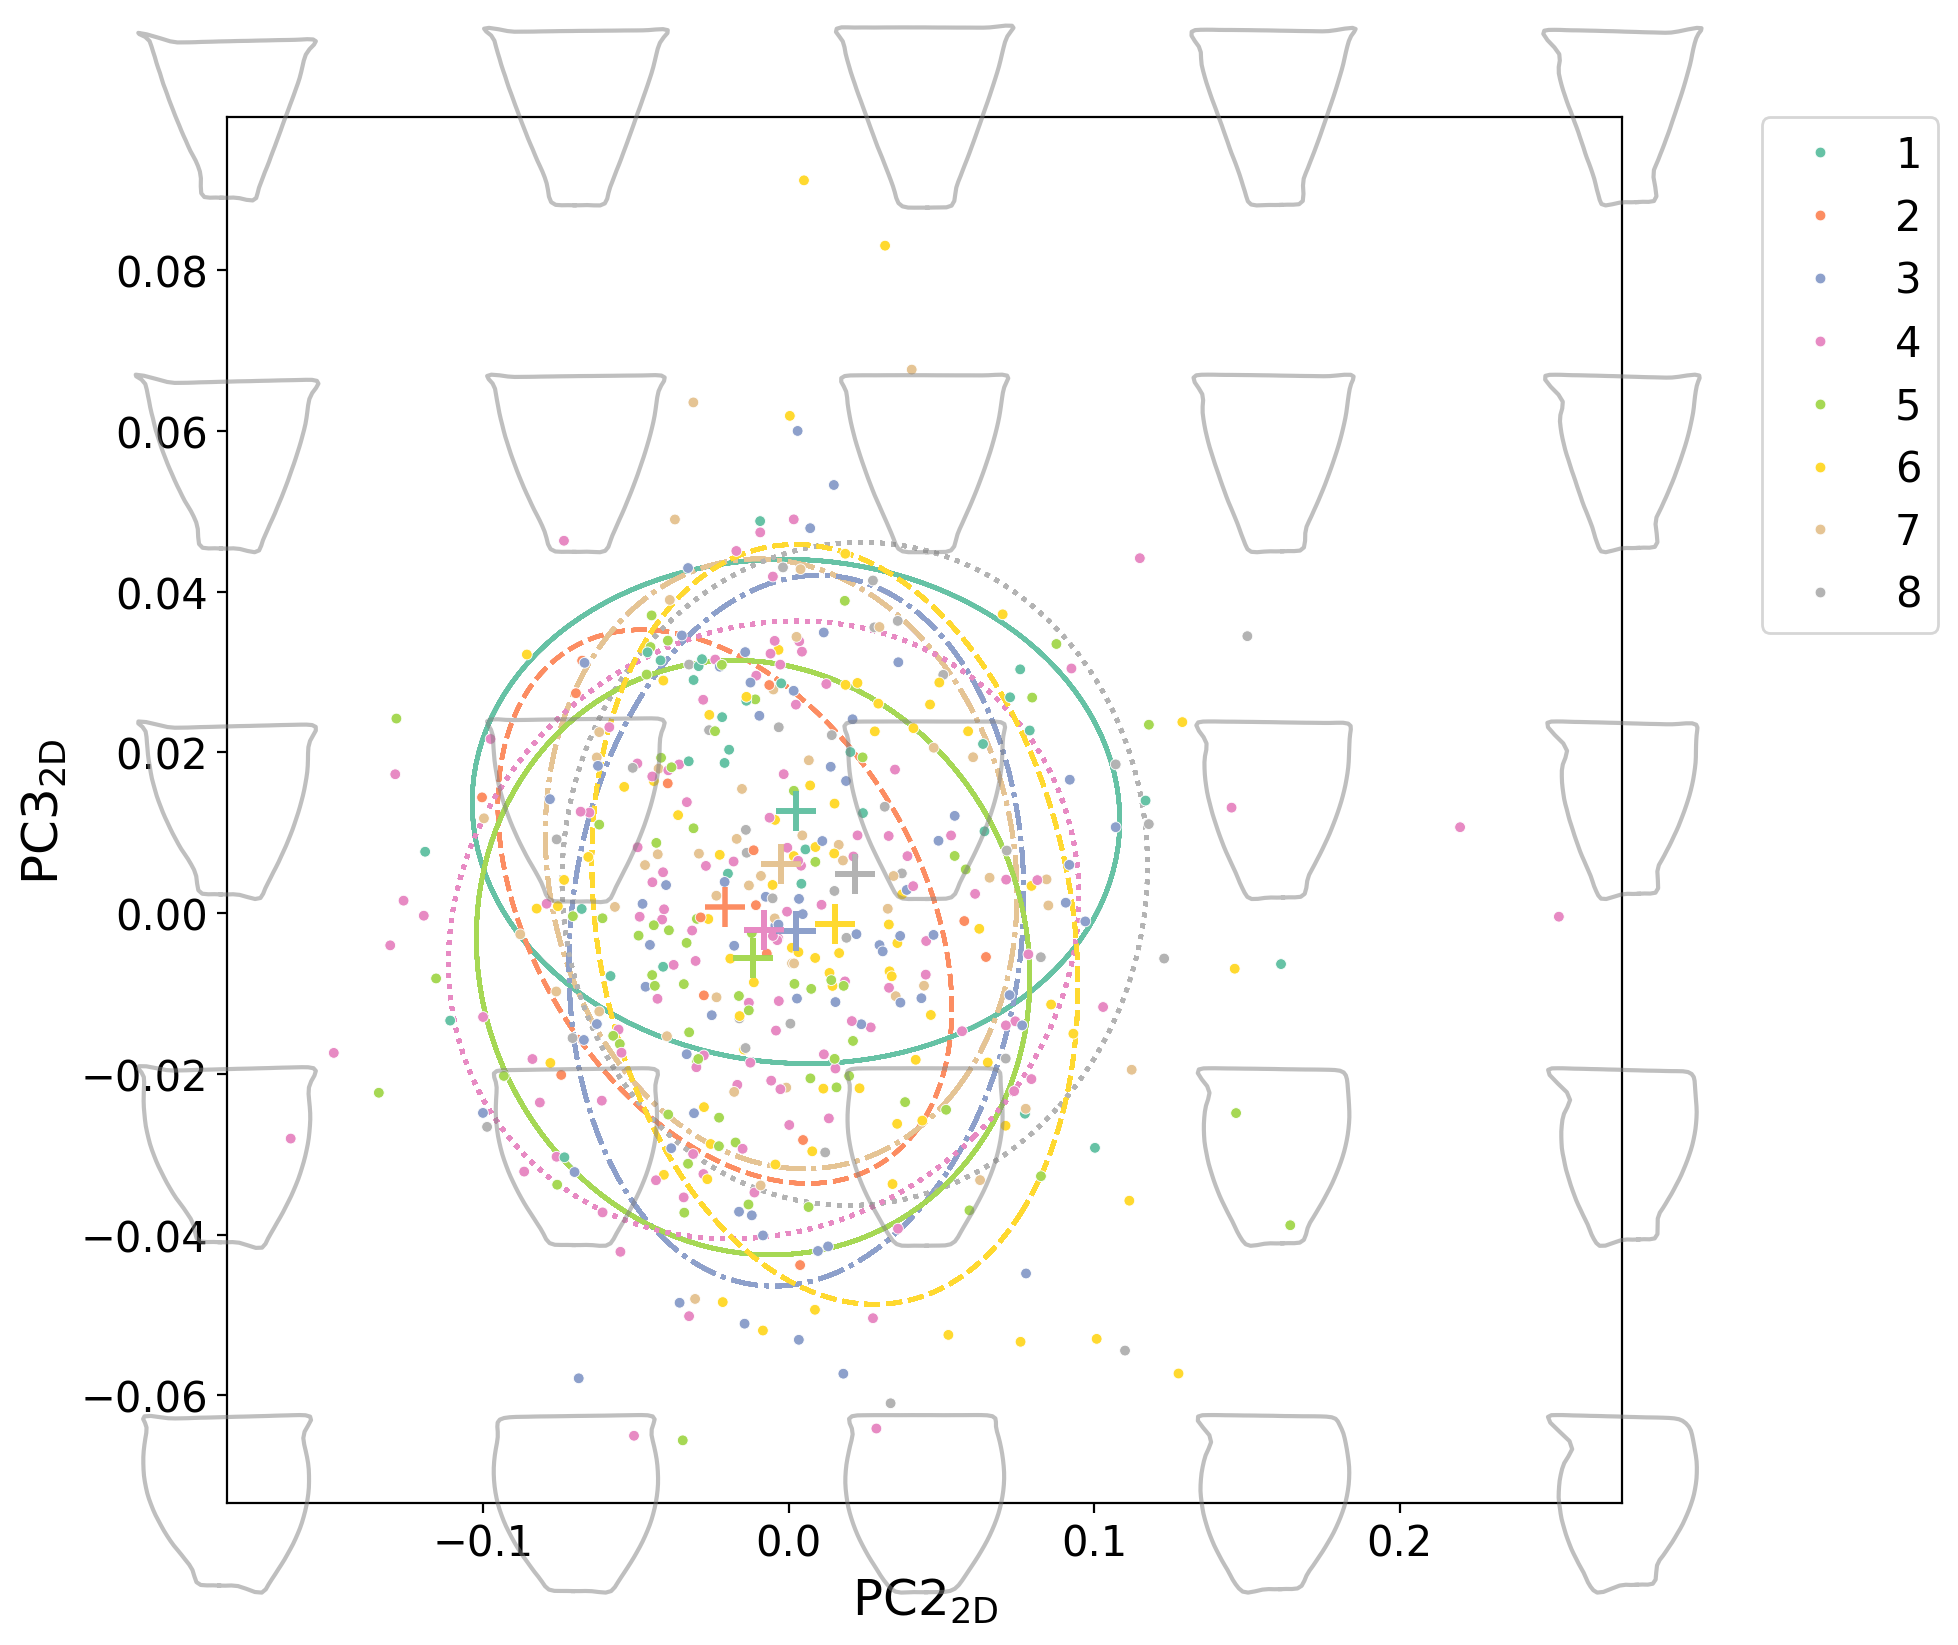

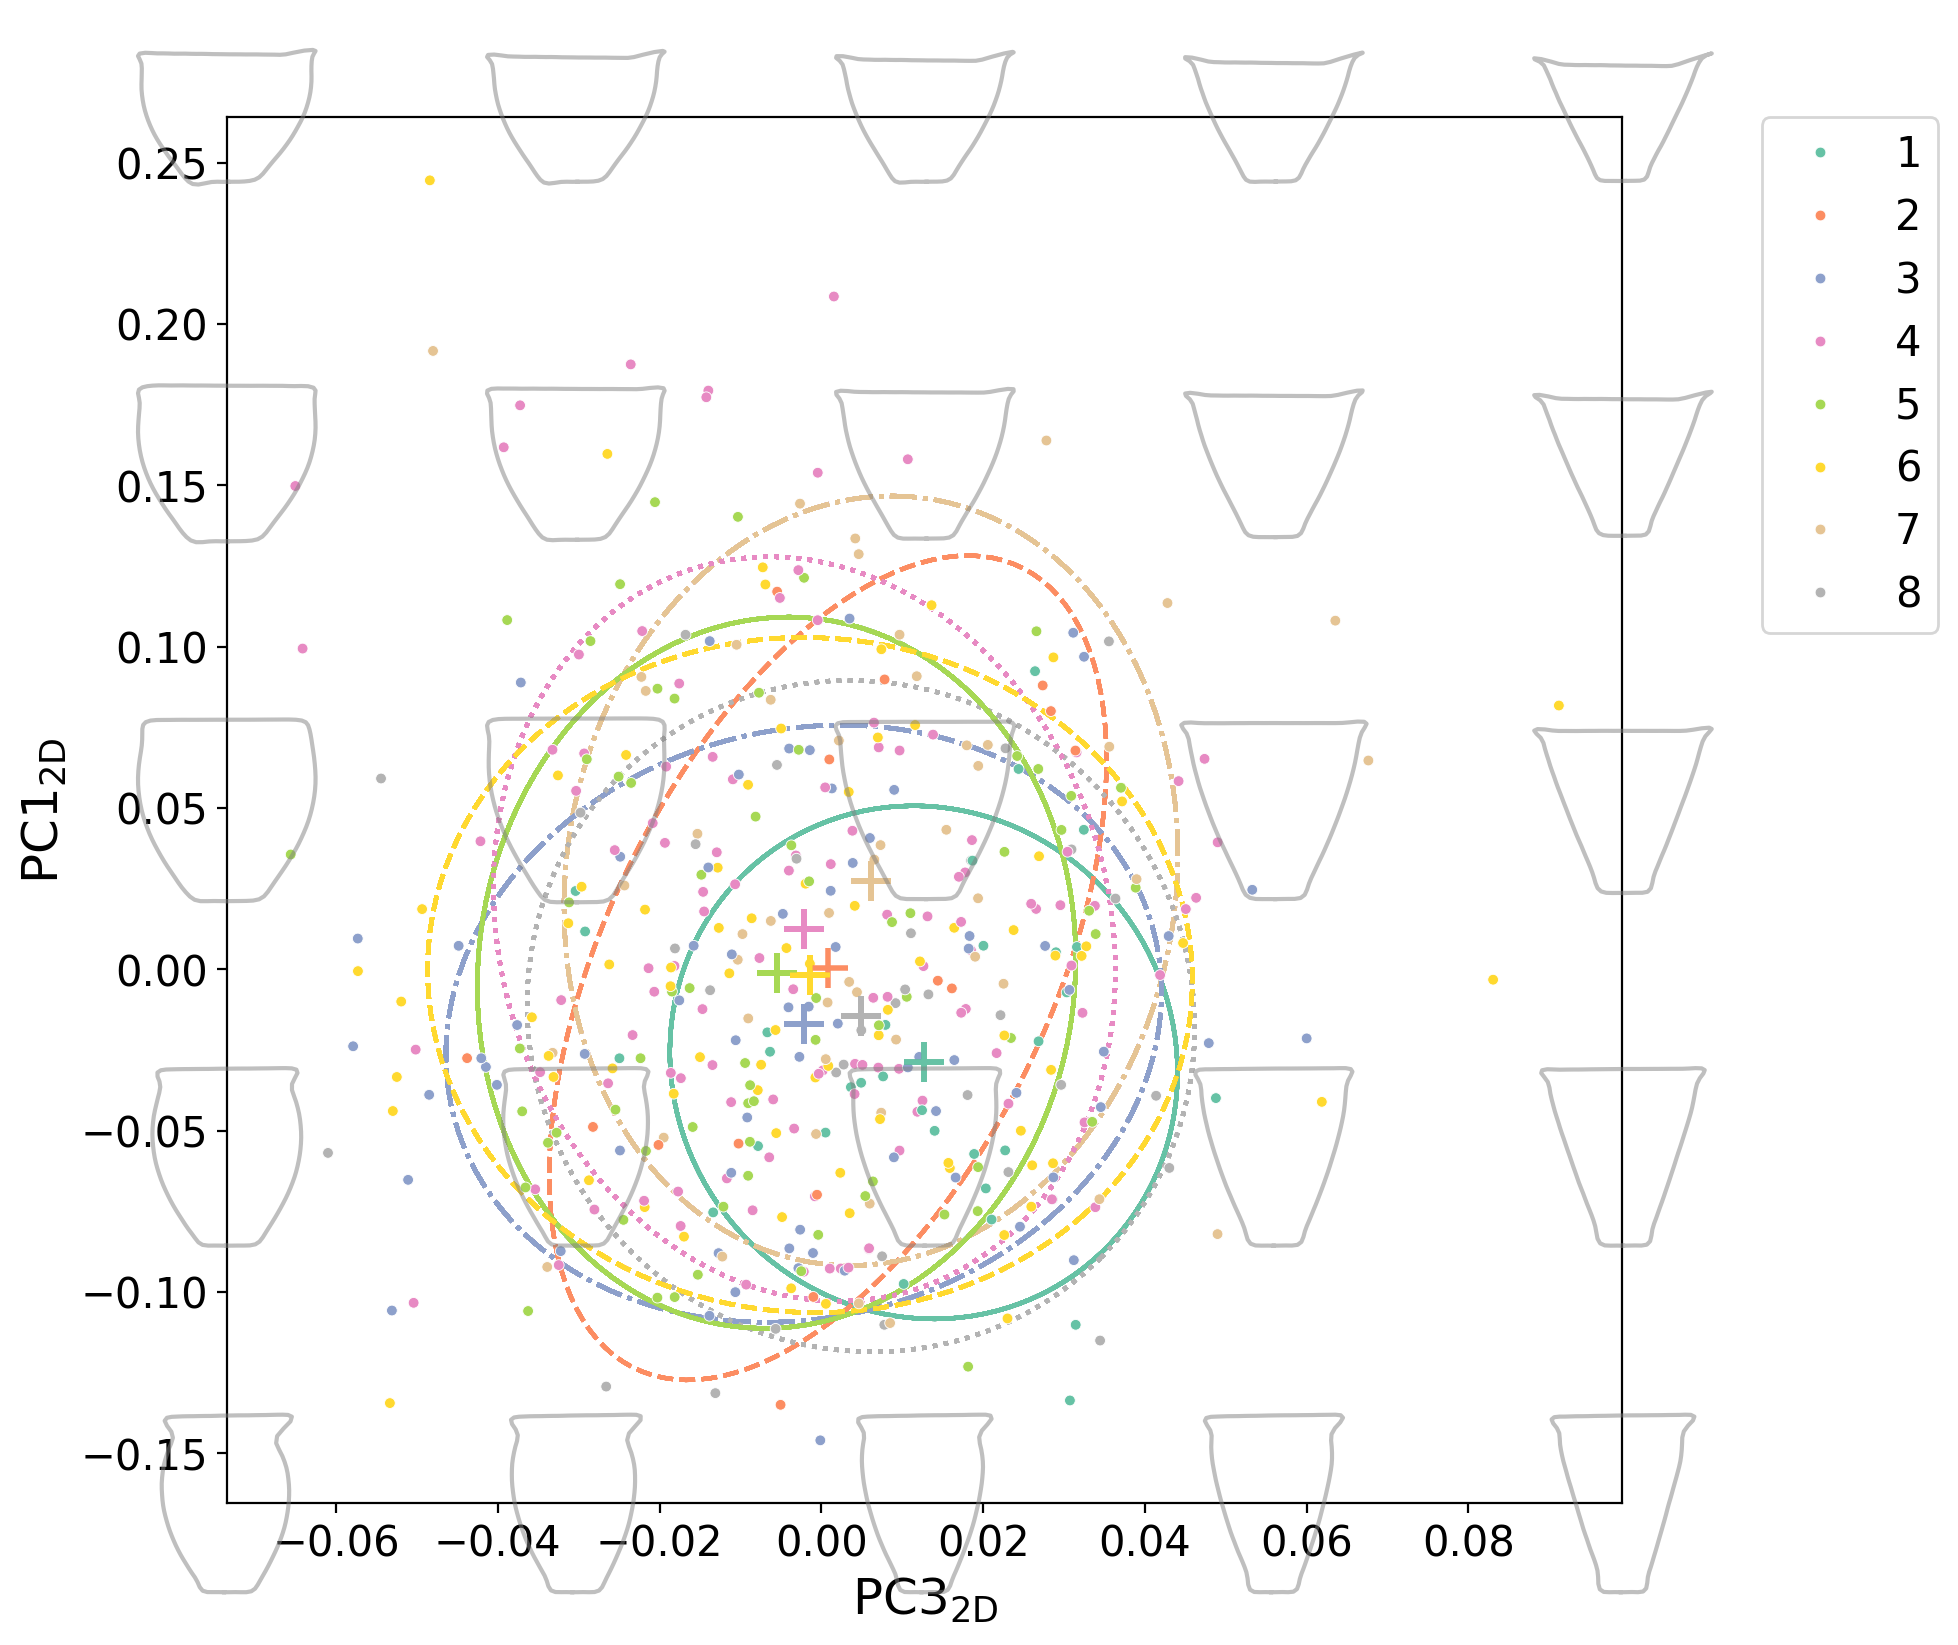

In [8]:
morph_num = 5
morph_scale = 0.7
morph_color = "gray"
morph_alpha = 0.5

efa = efa_h30
pca = pca_h30
df_pca = df_pca_h30


# CAT_ITEM = "area"
CAT_ITEM = "phase"
with_legend = True
# with_legend = False

conf_ellip_std = cvt_conf2std(0.8)
arr_pred_pca = df_pca_h30[["pca"+str(i) for i in range(30)]].to_numpy()
cat = df_pca_h30[CAT_ITEM].to_list()
cat_order = np.unique(cat)

HUE = CAT_ITEM

pc_pairs = [[1, 2], [2, 3], [3, 1]]
for i, j in pc_pairs:
    filename_suffix = ""
    
    fig = plt.figure(figsize=(9,9),dpi=200)

    ax = fig.add_subplot(1,1,1)
    sns.scatterplot(data=df_pca, x="pca"+str(i-1), y="pca"+str(j-1), hue=HUE, hue_order=cat_order, 
                    palette="Set2", ax = ax, legend = with_legend, zorder=2, s=15)

    plot_recon_morphs(pca, efa, morph_num=5, morph_scale=morph_scale,
                      hue=None,hue_order=None,
                      morph_color=morph_color, morph_alpha=morph_alpha,
                      fig = fig, ax = ax, n_PCs_xy = [i, j])

    plot_confidence_ellipse(arr_pred_pca, [i-1,j-1], cat, conf_ellip_std, ax, palette="Set2", center=True)

    if with_legend:
        ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0, fontsize=15)
        
        filename_suffix = filename_suffix + "_legend"

    ax.patch.set_alpha(0)
    ax.set_xlabel(xlabel=r'$\rm{PC' +str(i)+ '}_{2D}$', fontsize=18)
    ax.set_ylabel(ylabel=r'$\rm{PC' +str(j)+ '}_{2D}$', fontsize=18)
    ax.tick_params(labelsize=15)

## Phase

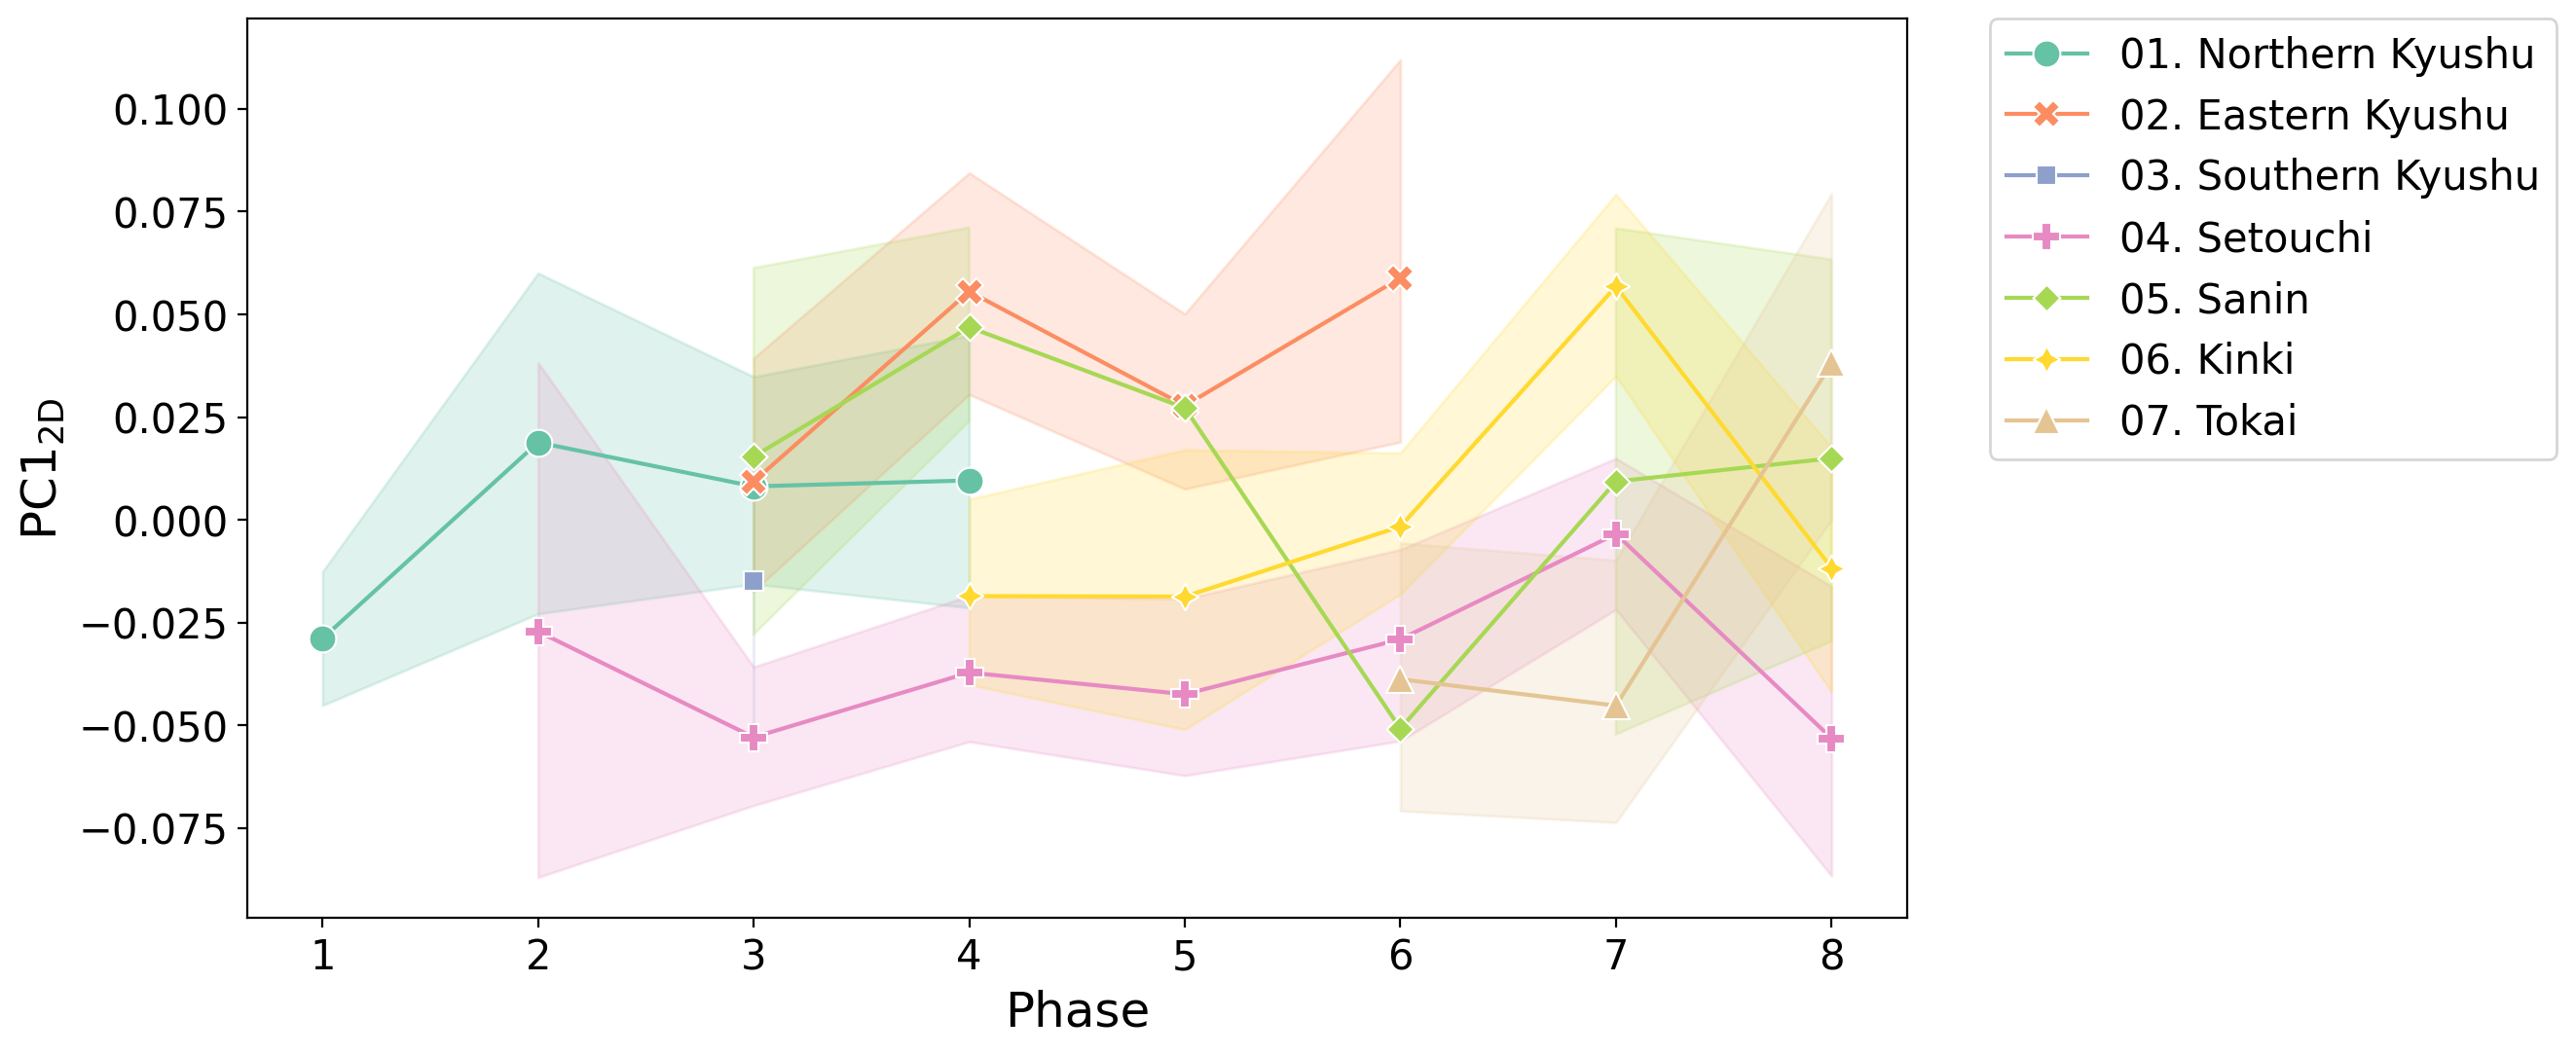

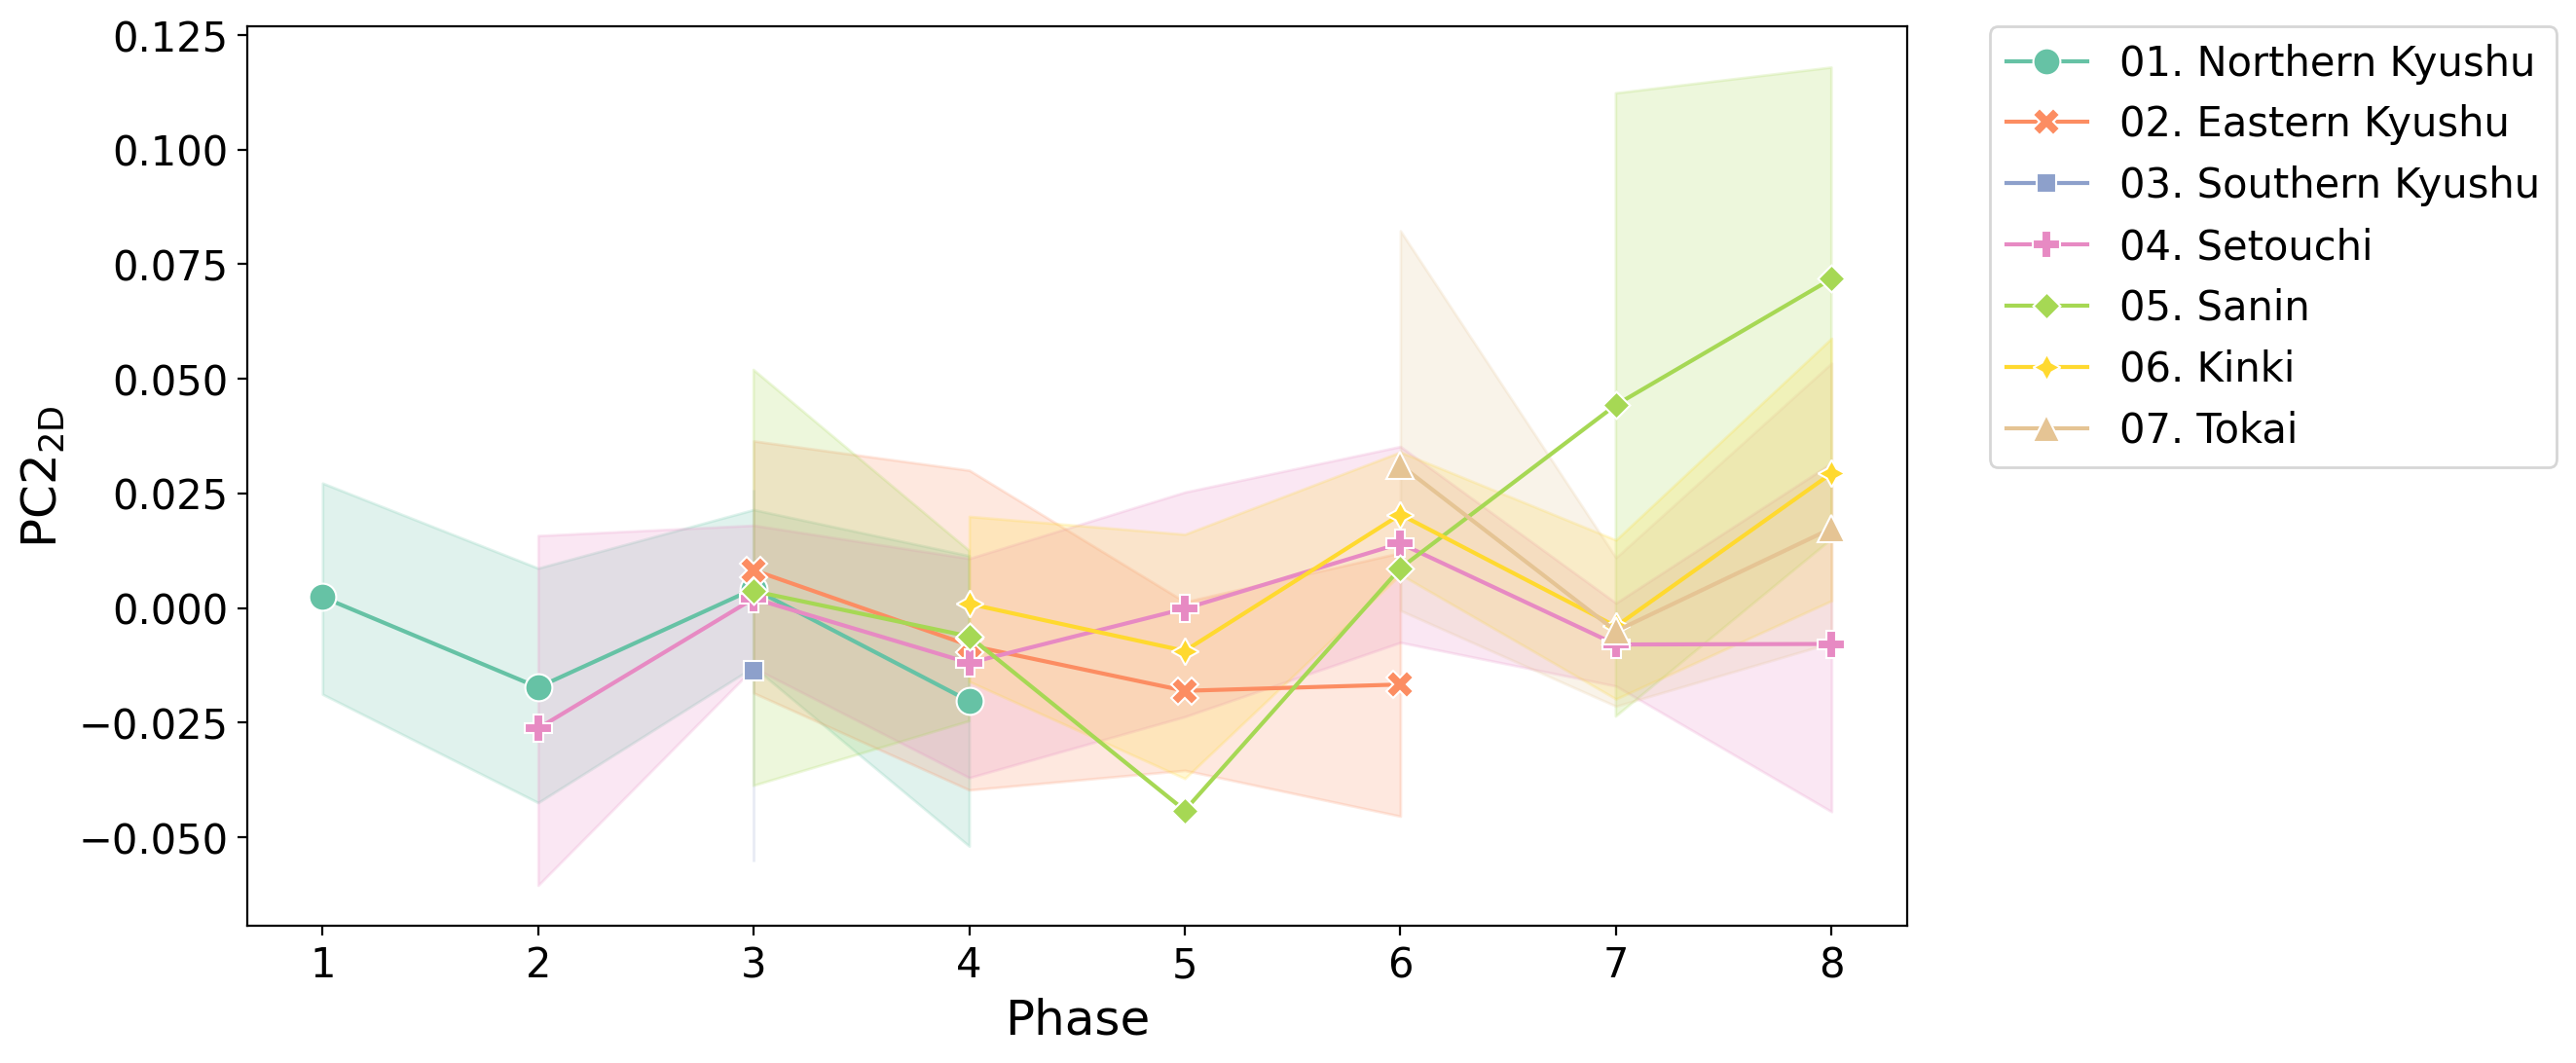

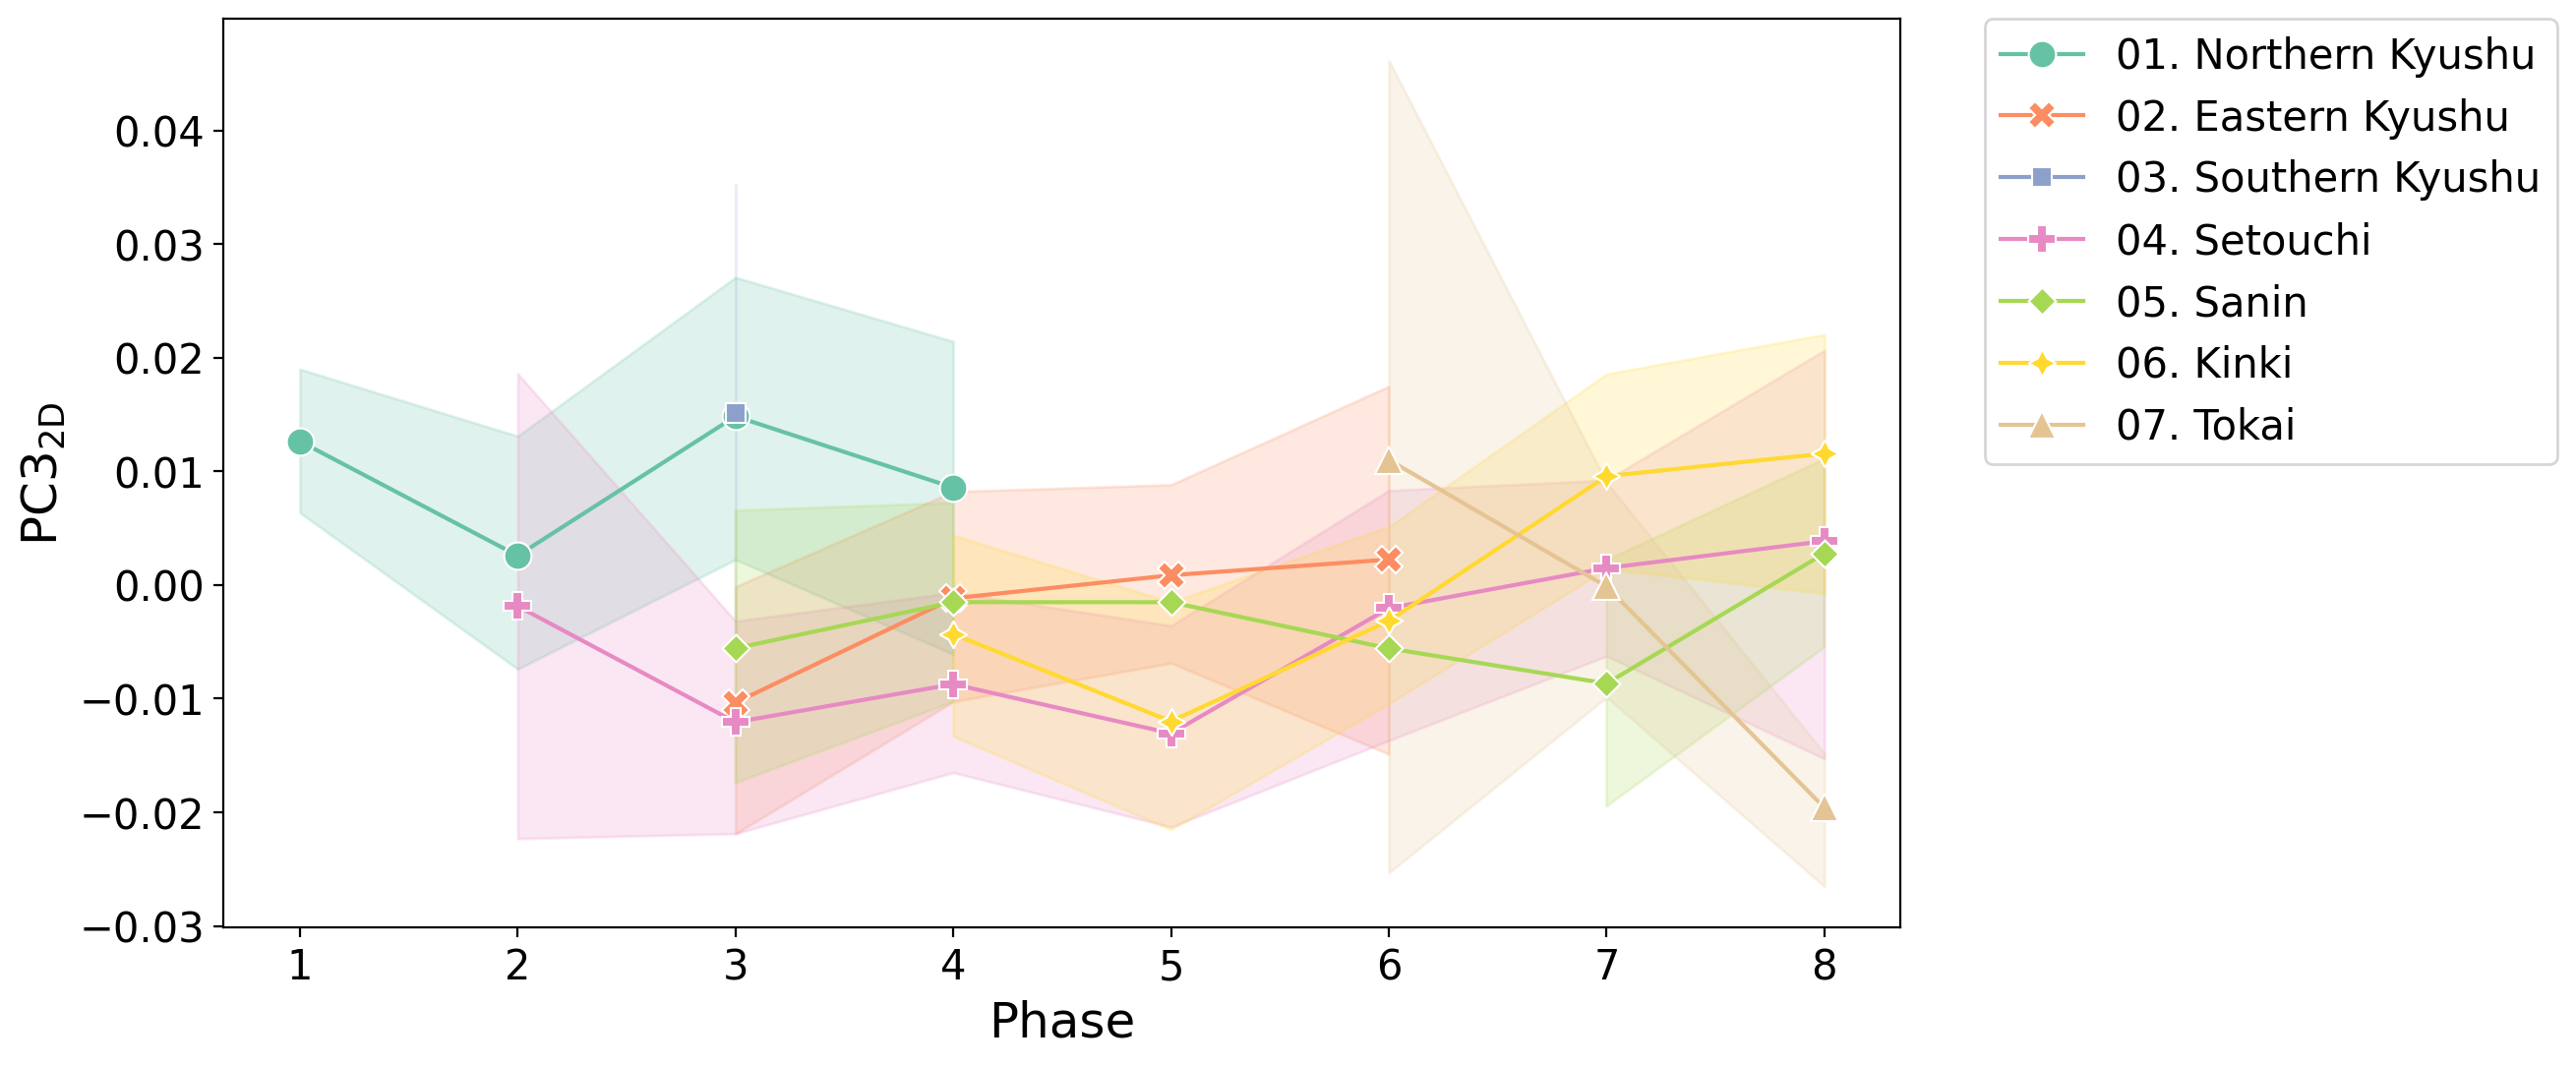

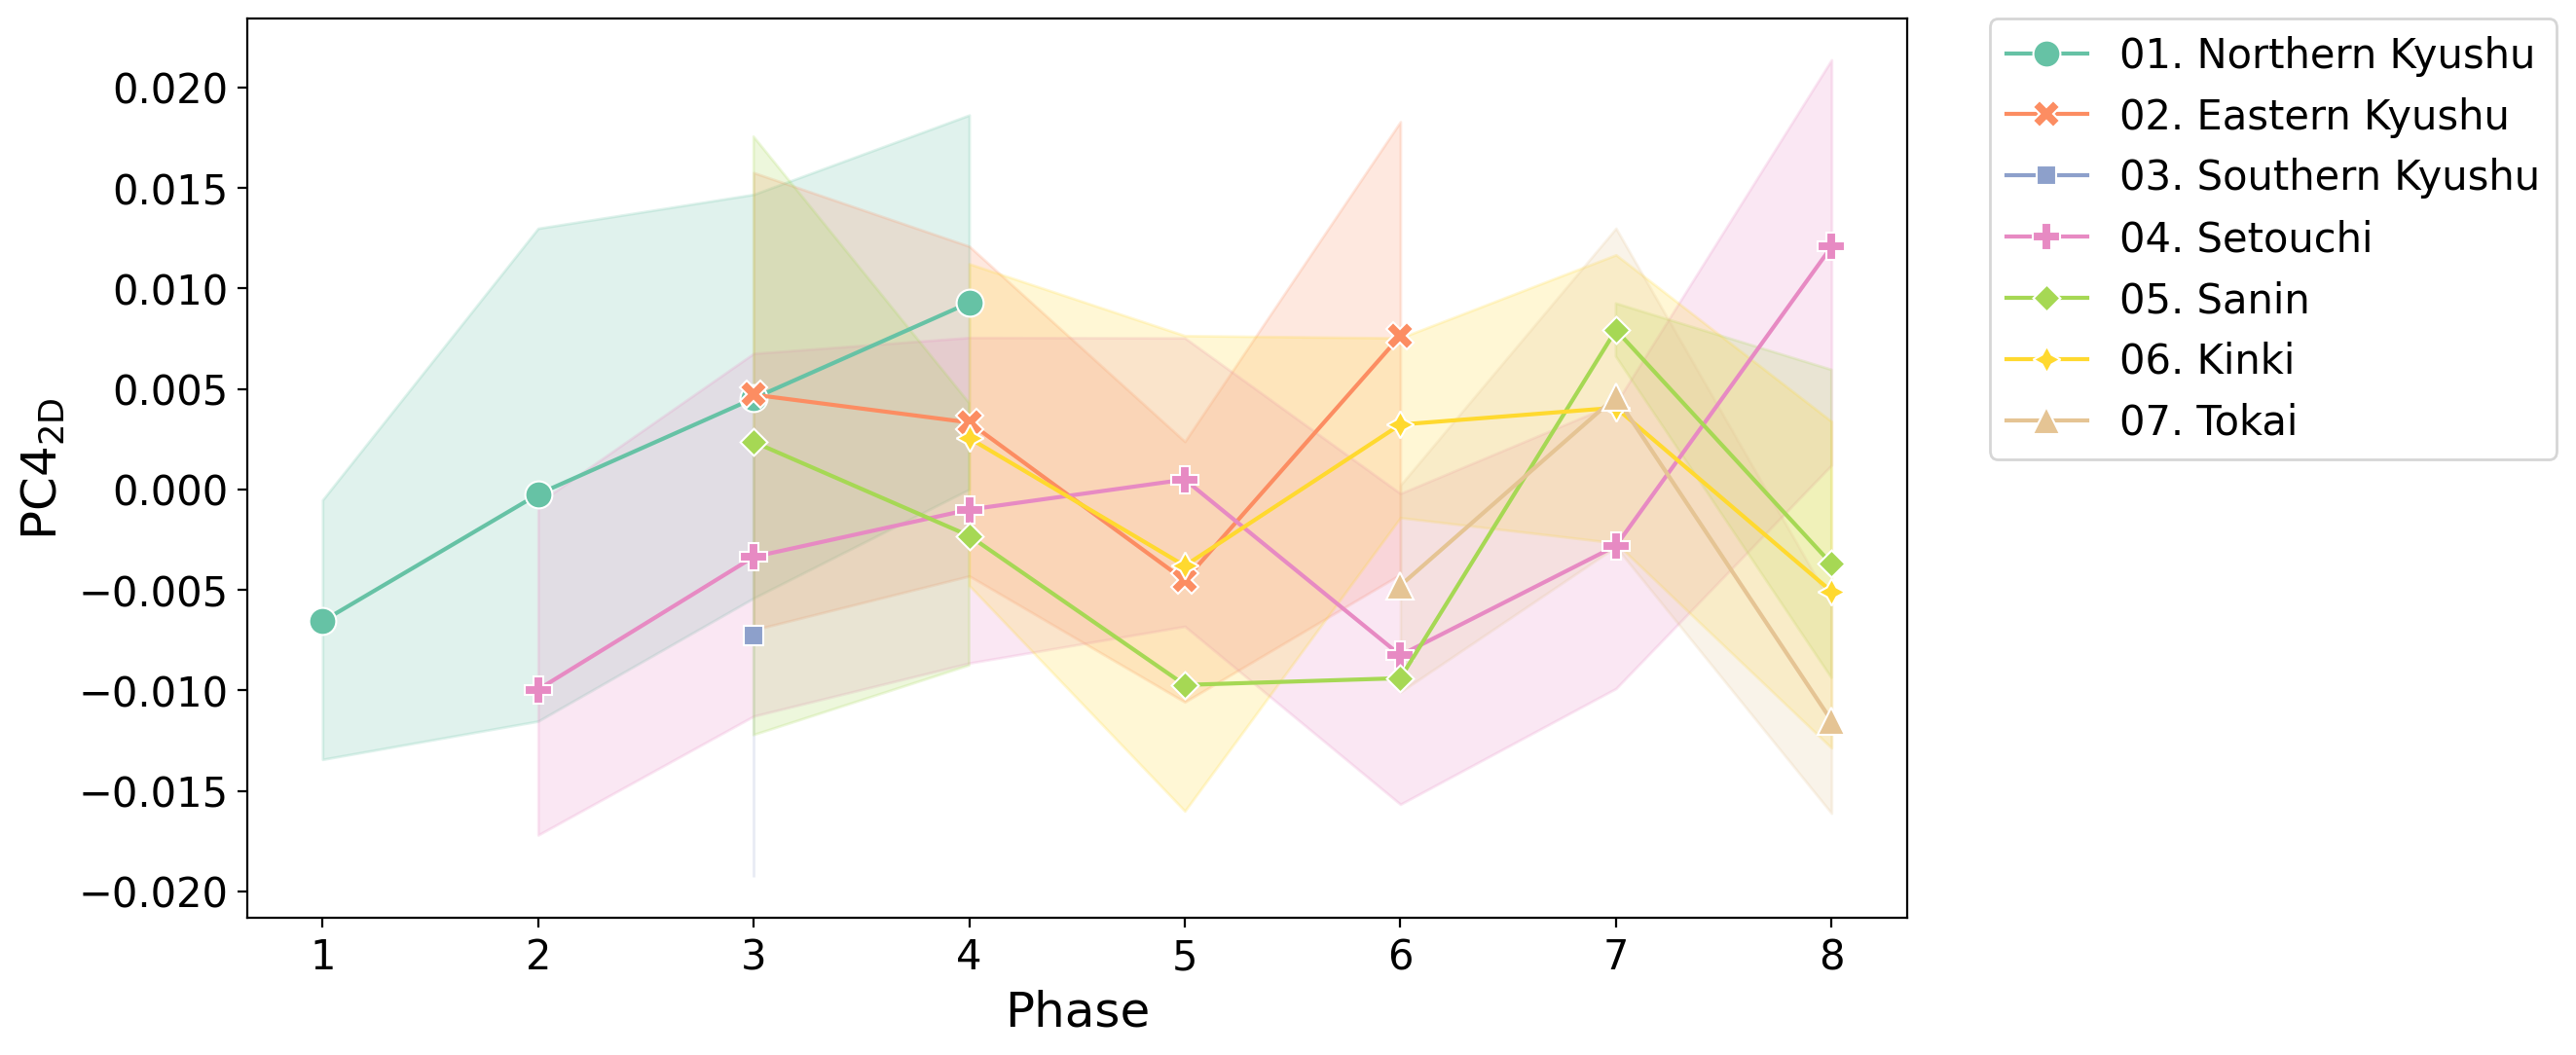

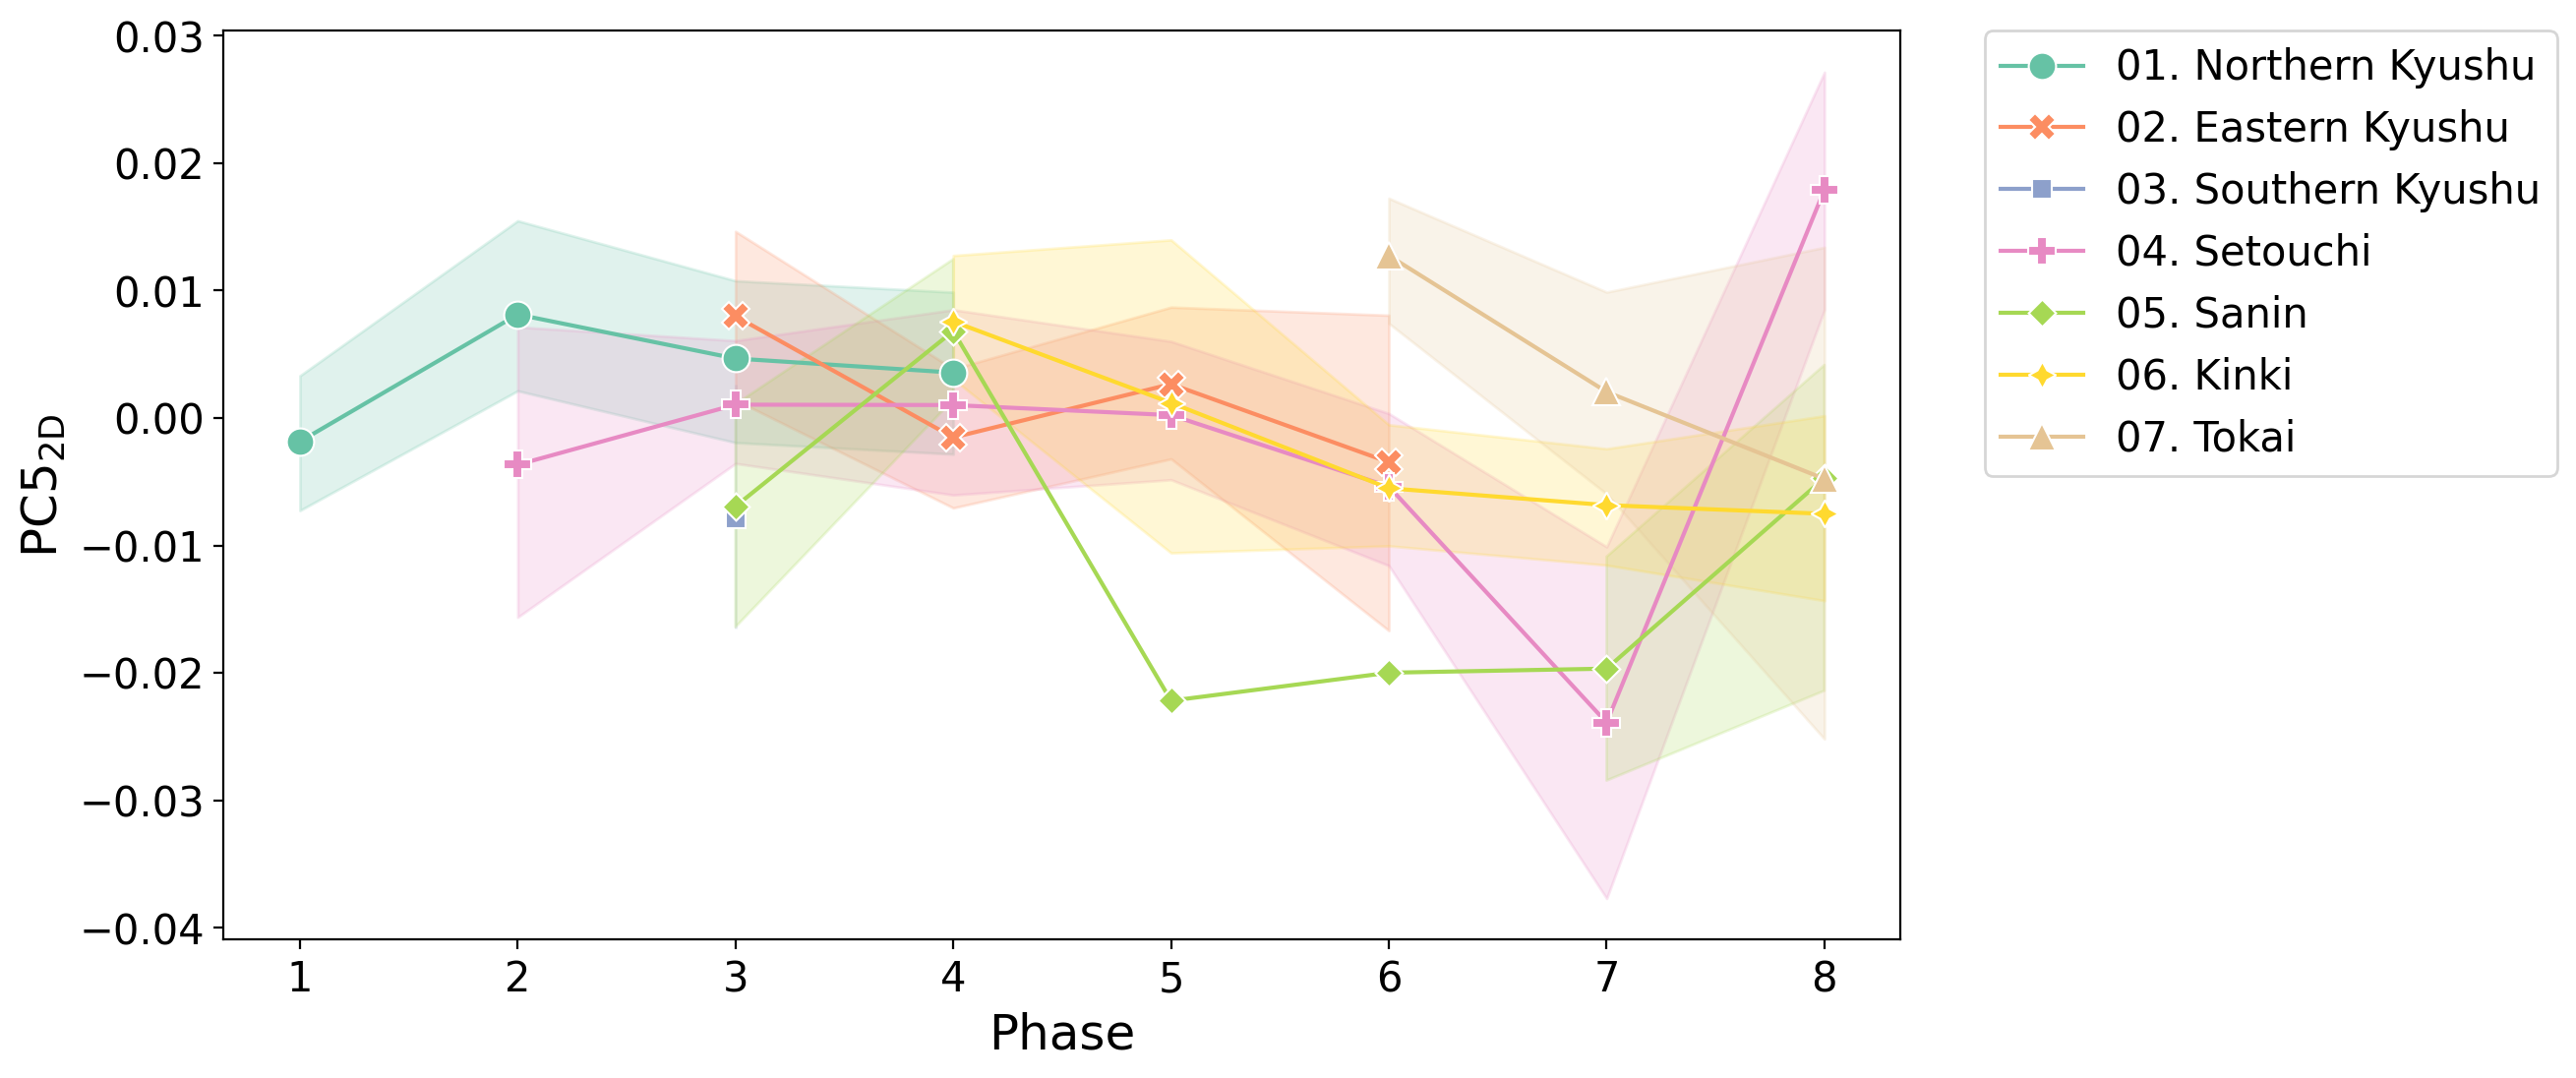

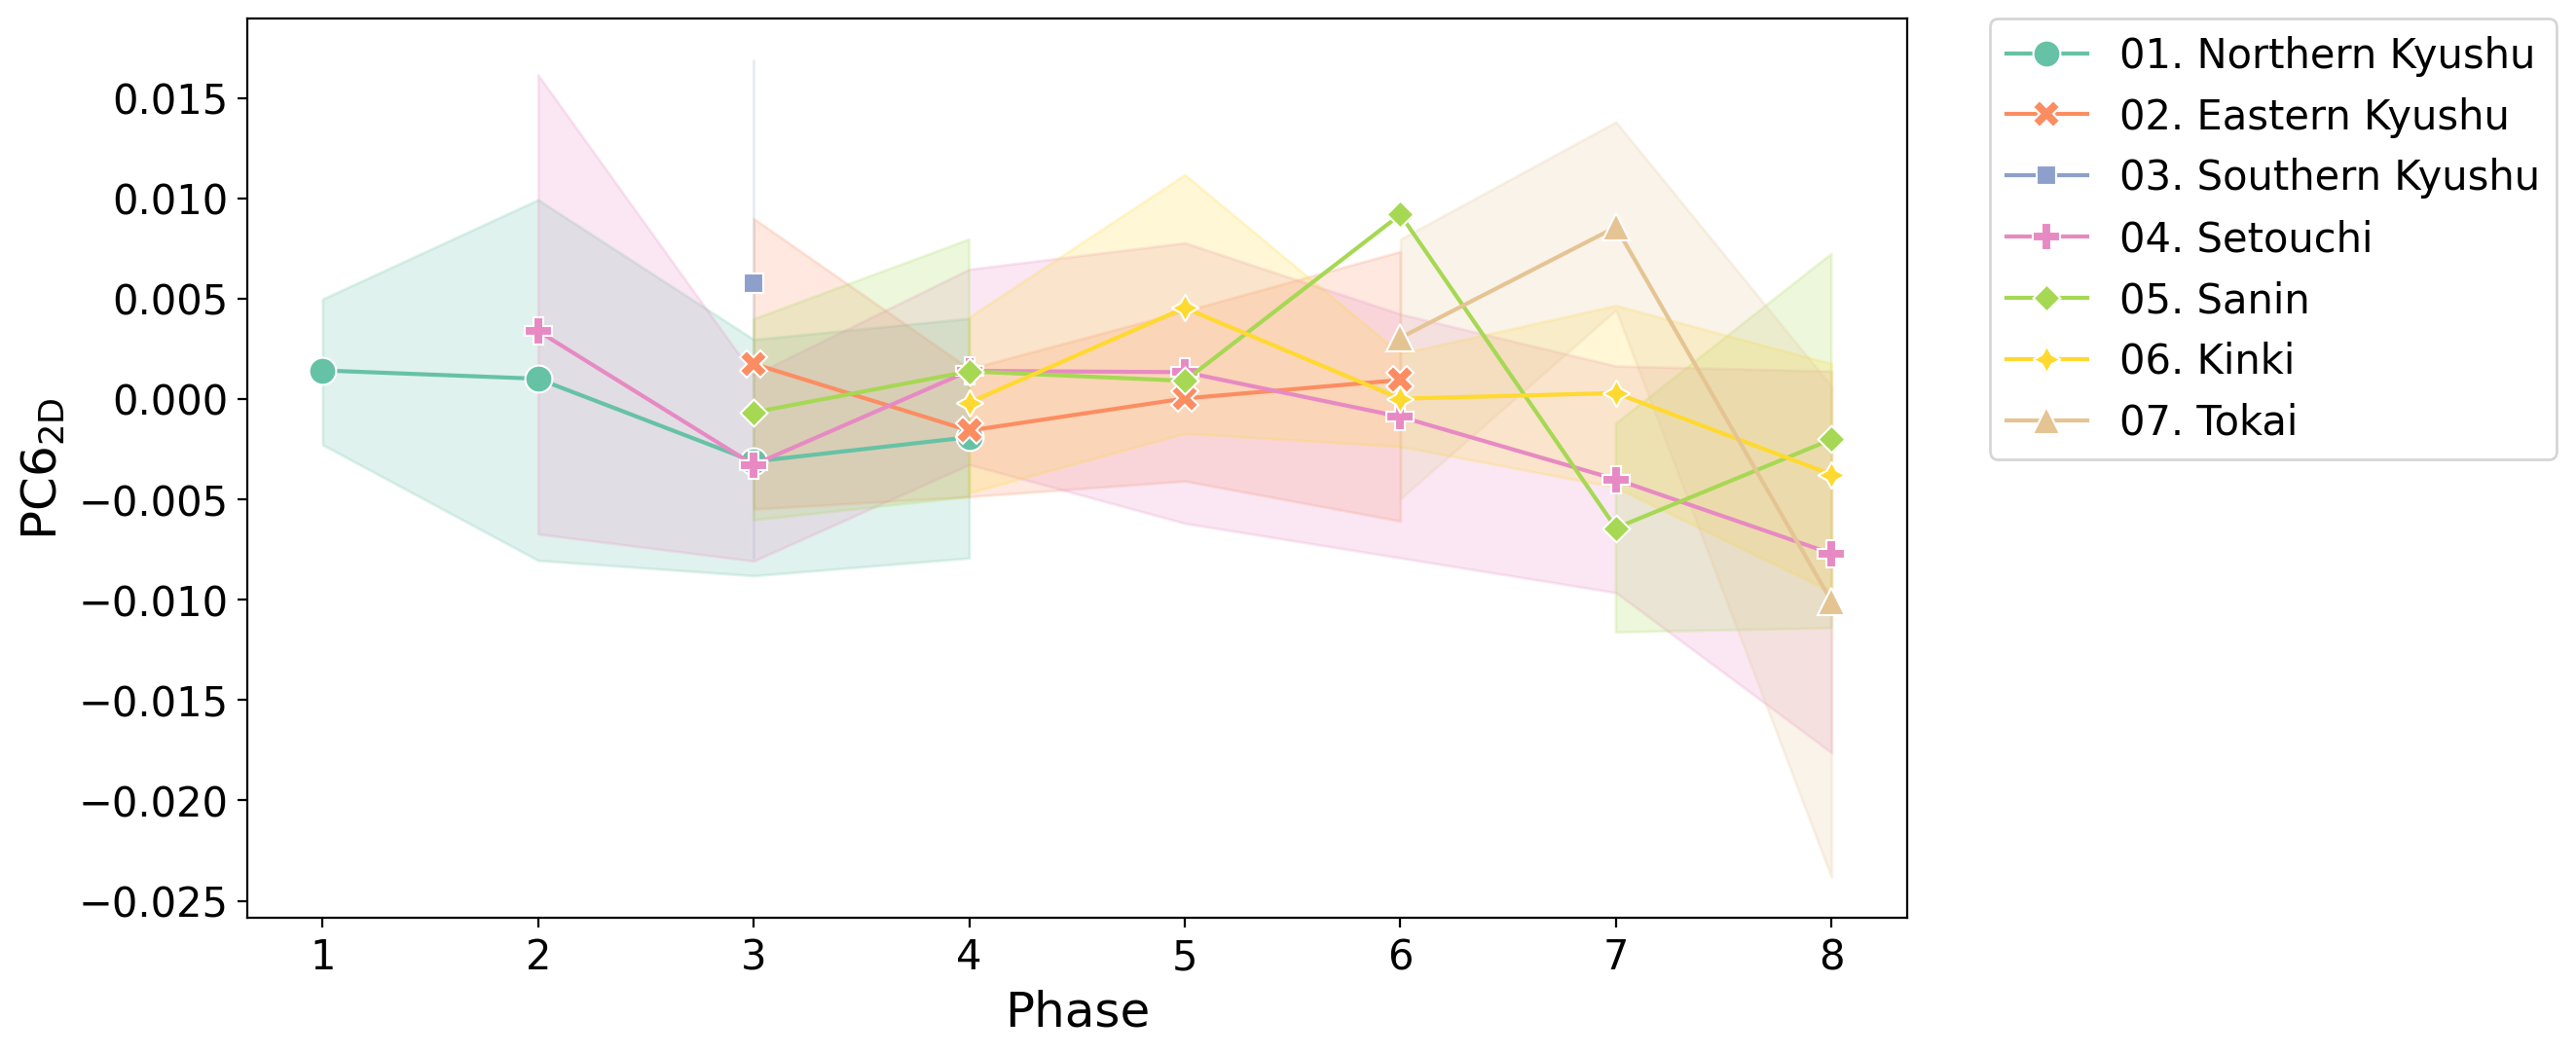

In [10]:
morph_num = 5
morph_scale = 0.7
morph_color = "gray"
morph_alpha = 0.5

efa = efa_h30
pca = pca_h30
df_pca = df_pca_h30

cat_order = np.unique(df_pca_h30["area"].to_list())

pc_axes = [1, 2, 3, 4, 5, 6]

with_legend = True
# with_legend = False

for i in pc_axes:
    filename_suffix = ""
    
    fig = plt.figure(figsize=(11,6),dpi=200)

    ax = fig.add_subplot(1,1,1)
    
    if with_legend:
        sns.lineplot(data=df_pca, x="phase", y="pca"+str(i-1), hue="area",style="area", hue_order=cat_order, style_order=cat_order,
                    palette="Set2", ax = ax, legend = True, markers=True, markersize = 10, dashes=False)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=15)        
        filename_suffix = filename_suffix + "_legend"
    else: 
        sns.lineplot(data=df_pca, x="phase", y="pca"+str(i-1), hue="area",style="area", hue_order=cat_order, style_order=cat_order,
                    palette="Set2", ax = ax, legend = False, markers=True, markersize = 10, dashes=False)
    
    

    ax.patch.set_alpha(0)
    ax.set_xlabel(xlabel='Phase', fontsize=18)
    ax.set_ylabel(ylabel=r'$\rm{PC' +str(i)+ '}_{2D}$', fontsize=18)
    ax.tick_params(labelsize=15)